# **Importing Libraries and Dataset**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


df=pd.read_csv("/content/cleaned_merged_with_scores.csv")

<ipython-input-4-f5c94d19b66f>:13: DtypeWarning: Columns (10,11,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/content/cleaned_merged_with_scores.csv")


In [ ]:
df

rentfaster_id     city province           address   latitude  \
0             468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962   
1             468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962   
2             468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962   
3             468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962   
4             468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962   
...              ...      ...      ...               ...        ...   
95498         572106  Calgary  Alberta          Evanston  51.174964   
95499         572106  Calgary  Alberta          Evanston  51.174964   
95500         572106  Calgary  Alberta          Evanston  51.174964   
95501         572106  Calgary  Alberta          Evanston  51.174964   
95502         572106  Calgary  Alberta          Evanston  51.174964   

        longitude lease_term       type   price    beds baths sq_feet  \
0     -114.012515  Long Term  Townhouse  2495.0  2 Beds   2.5    1403   
1     -114.012515  Long Term  Townhouse  2495.0  2 Beds   2.5    1403   
2     -114.012515  Long Term  Townhouse  2495.0  2 Beds   2.5    1403   
3     -114.012515  Long Term  Townhouse  2495.0  2 Beds   2.5    1403   
4     -114.012515  Long Term  Townhouse  2495.0  2 Beds   2.5    1403   
...           ...        ...        ...     ...     ...   ...     ...   
95498 -114.103904  Long Term      House  3400.0  4 Beds     3     NaN   
95499 -114.103904  Long Term      House  3400.0  4 Beds     3     NaN   
95500 -114.103904  Long Term      House  3400.0  4 Beds     3     NaN   
95501 -114.103904  Long Term      House  3400.0  4 Beds     3     NaN   
95502 -114.103904  Long Term      House  3400.0  4 Beds     3     NaN   

                                                    link   furnishing  \
0      /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...  Unfurnished   
1      /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...  Unfurnished   
2      /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...  Unfurnished   
3      /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...  Unfurnished   
4      /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...  Unfurnished   
...                                                  ...          ...   
95498  /ab/calgary/rentals/house/4-bedrooms/evanston/...  Unfurnished   
95499  /ab/calgary/rentals/house/4-bedrooms/evanston/...  Unfurnished   
95500  /ab/calgary/rentals/house/4-bedrooms/evanston/...  Unfurnished   
95501  /ab/calgary/rentals/house/4-bedrooms/evanston/...  Unfurnished   
95502  /ab/calgary/rentals/house/4-bedrooms/evanston/...          NaN   

      availability_date      smoking  cats  dogs  Walk Score  Bike Score  
0             Immediate  Non-Smoking  True  True        61.0        44.0  
1             Immediate  Non-Smoking  True  True        61.0        44.0  
2             Immediate  Non-Smoking  True  True        61.0        44.0  
3             Immediate  Non-Smoking  True  True        61.0        44.0  
4             Immediate  Non-Smoking  True  True        61.0        44.0  
...                 ...          ...   ...   ...         ...         ...  
95498         Immediate  Non-Smoking  True  True        63.0        58.0  
95499         Immediate  Non-Smoking  True  True        63.0        58.0  
95500         Immediate  Non-Smoking  True  True        63.0        58.0  
95501         Immediate  Non-Smoking  True  True        63.0        58.0  
95502               NaN          NaN   NaN   NaN         NaN         NaN  

[95503 rows x 20 columns]

In [ ]:
df.type.unique()

array(['Townhouse', 'Apartment', 'Main Floor', 'House', 'Basement',
       'Condo Unit', 'Room For Rent', 'Duplex', 'Loft', 'Storage',
       'Office Space', 'Parking Spot', 'Vacation Home', 'Acreage',
       'Mobile'], dtype=object)

# **Preprocessing**

In [ ]:

columns_to_drop = ['rentfaster_id', 'address', 'link']
df = df.drop(columns=columns_to_drop, errors='ignore')


df = df.dropna()



df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


df = df[~df.isin(['none']).any(axis=1)]



df['studio'] = df['beds'].str.contains('studio', case=False, na=False).astype(int)


df['beds'] = df['beds'].str.replace('studio', '1 Bed', case=False)


df['beds'] = df['beds'].str.extract('(\d+)').astype(float)
df['sq_feet'] = df['sq_feet'].str.extract('(\d+)').astype(float)


categorical_columns = ['city', 'province', 'lease_term', 'type', 'furnishing', 'availability_date', 'smoking']
label_encoders = {}
for col in categorical_columns:
    if df[col].dtype == 'object':  
        df[col] = df[col].str.strip().str.lower().replace('none', 'unknown')  
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

<ipython-input-5-d9392a810653>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


# **Model**

## **Feature Selection**

In [ ]:

features = ['city', 'province', 'latitude', 'longitude', 'lease_term', 'type', 'beds', 'baths', 'sq_feet',
            'furnishing', 'availability_date', 'smoking', 'cats', 'dogs', 'Walk Score', 'Bike Score','studio']
target = 'price'

X = df[features]
y = df[target]

## **Scaling**

In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **Splitting the dataset into training and testing**

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## **XG BOOST**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score





scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



# XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
xgb_train_score = xgb_model.score(X_train, y_train)
xgb_test_score = xgb_model.score(X_test, y_test)
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost Train Score: {xgb_train_score:.2f}")
print(f"XGBoost Test Score: {xgb_test_score:.2f}")
print(f"MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, R2: {r2_xgb:.2f}")



XGBoost Train Score: 0.96
XGBoost Test Score: 0.96
MAE: 116.99, MSE: 32744.09, R2: 0.96


              Feature  Importance
7               baths    0.328997
8             sq_feet    0.096866
15         Bike Score    0.085779
9          furnishing    0.063701
5                type    0.055508
14         Walk Score    0.054483
12               cats    0.050399
16             studio    0.048742
3           longitude    0.047052
13               dogs    0.040951
4          lease_term    0.033227
6                beds    0.025838
2            latitude    0.017136
10  availability_date    0.015196
11            smoking    0.014411
1            province    0.013453
0                city    0.008259


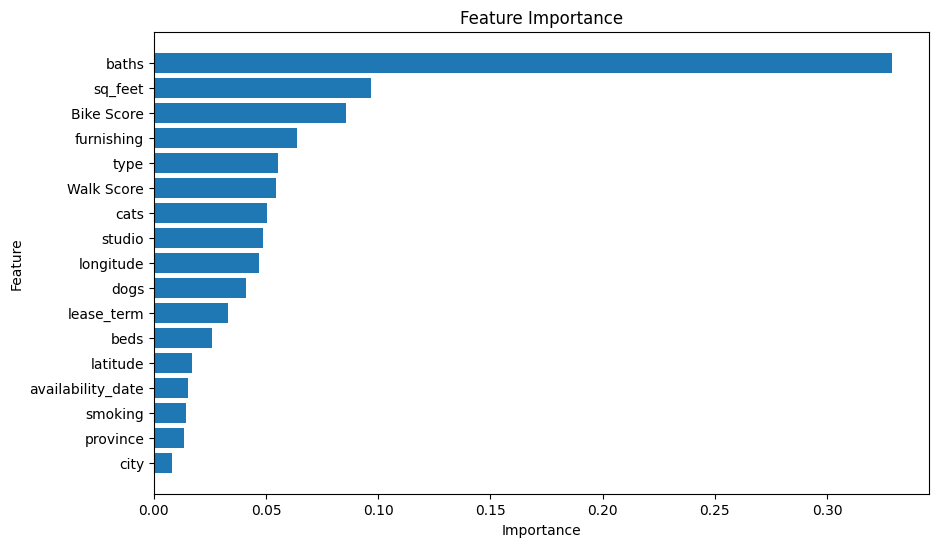

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = xgb_model.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': features,  
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


print(feature_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()


## **Cat Boost**

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=100)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)


0:	learn: 817.7001897	total: 18.3ms	remaining: 18.3s
100:	learn: 265.4952700	total: 1.73s	remaining: 15.4s
200:	learn: 213.8932181	total: 3.38s	remaining: 13.4s
300:	learn: 187.0203236	total: 6.42s	remaining: 14.9s
400:	learn: 171.3208187	total: 9.34s	remaining: 13.9s
500:	learn: 159.9061357	total: 11.6s	remaining: 11.6s
600:	learn: 151.2174622	total: 13.3s	remaining: 8.85s
700:	learn: 143.3082012	total: 15.1s	remaining: 6.42s
800:	learn: 137.5469503	total: 16.7s	remaining: 4.15s
900:	learn: 132.1213550	total: 19.4s	remaining: 2.13s
999:	learn: 127.6176996	total: 25.7s	remaining: 0us


In [ ]:
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)


print(f"CatBoost Model Evaluation:")
print(f"MAE: {mae_catboost:.2f}")
print(f"MSE: {mse_catboost:.2f}")
print(f"R²: {r2_catboost:.2f}")

CatBoost Model Evaluation:
MAE: 79.37
MSE: 17973.28
R²: 0.98


              Feature  Importance
8             sq_feet   26.539867
7               baths   17.431686
14         Walk Score   11.853338
15         Bike Score    9.992362
3           longitude    8.341856
5                type    7.533216
9          furnishing    3.947727
2            latitude    3.940340
6                beds    3.340920
13               dogs    2.332629
10  availability_date    1.795880
4          lease_term    1.568339
0                city    0.437396
16             studio    0.419901
12               cats    0.317566
11            smoking    0.206889
1            province    0.000087


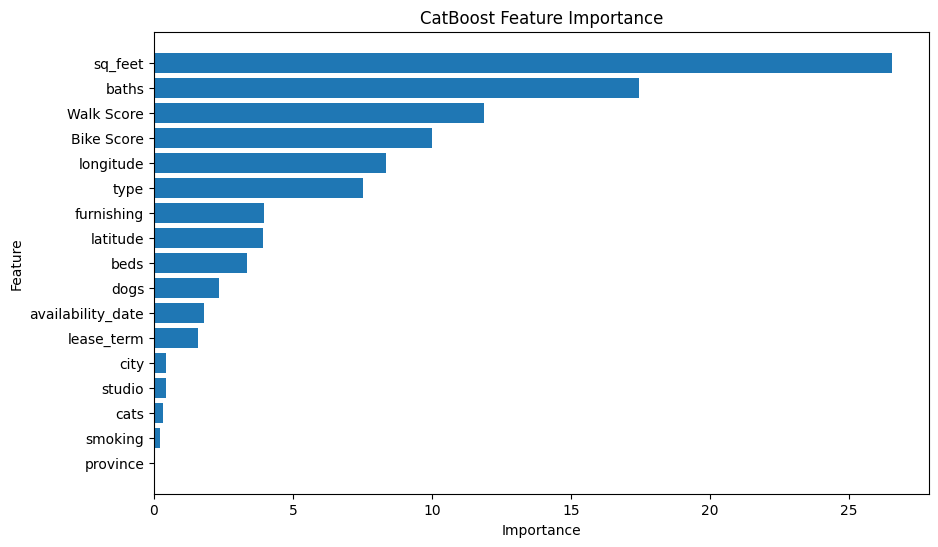

In [ ]:
importances = catboost_model.get_feature_importance()
importances

catboost_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


print(catboost_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(catboost_importance_df['Feature'], catboost_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## **LGBMRegressor**

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
lgbm_model.fit(X_train, y_train)


y_pred_lgbm = lgbm_model.predict(X_test)


mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM Model Evaluation:")
print(f"MAE: {mae_lgbm:.2f}")
print(f"MSE: {mse_lgbm:.2f}")
print(f"R²: {r2_lgbm:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1190
[LightGBM] [Info] Number of data points in the train set: 108868, number of used features: 17
[LightGBM] [Info] Start training from score 2181.868659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

              Feature  Importance
8             sq_feet         530
3           longitude         368
2            latitude         353
14         Walk Score         289
15         Bike Score         236
5                type         200
7               baths         195
6                beds         128
10  availability_date         121
9          furnishing          97
4          lease_term          85
0                city          54
13               dogs          45
11            smoking          31
12               cats          27
16             studio          13
1            province           6


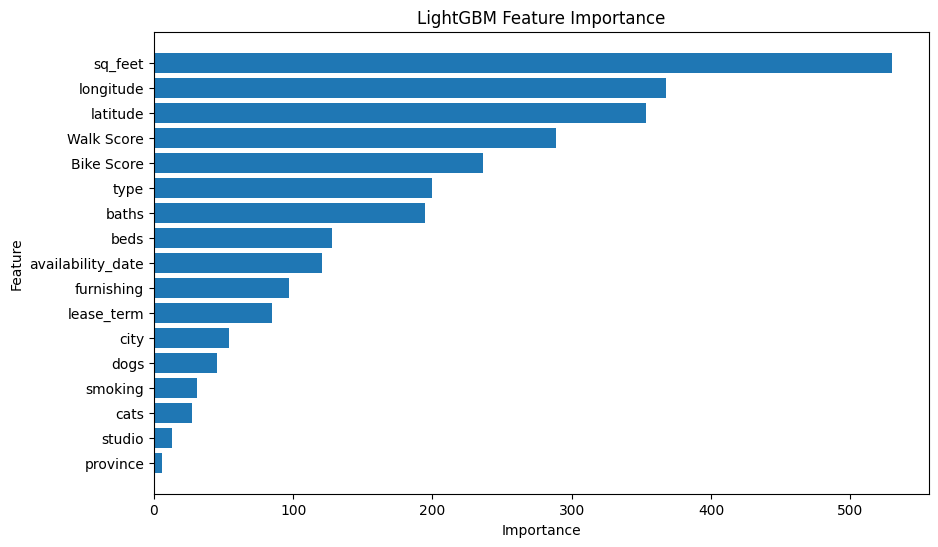

In [ ]:

importances = lgbm_model.feature_importances_


lgbm_importance_df = pd.DataFrame({
    'Feature': features,  
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


print(lgbm_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(lgbm_importance_df['Feature'], lgbm_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## **Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
def clean_data(X, y):
    
    X = np.nan_to_num(X)  
    y = np.nan_to_num(y)
    return X, y
X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting Regressor Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_gb:.2f}")
print(f"Mean Squared Error (MSE): {mse_gb:.2f}")
print(f"R² Score: {r2_gb:.2f}")

              Feature  Importance
8             sq_feet    0.326800
7               baths    0.232013
15         Bike Score    0.099564
3           longitude    0.089807
14         Walk Score    0.066395
5                type    0.062719
2            latitude    0.034116
9          furnishing    0.029662
6                beds    0.015860
10  availability_date    0.011181
4          lease_term    0.010964
13               dogs    0.008023
0                city    0.004450
12               cats    0.004382
16             studio    0.002462
11            smoking    0.001488
1            province    0.000115


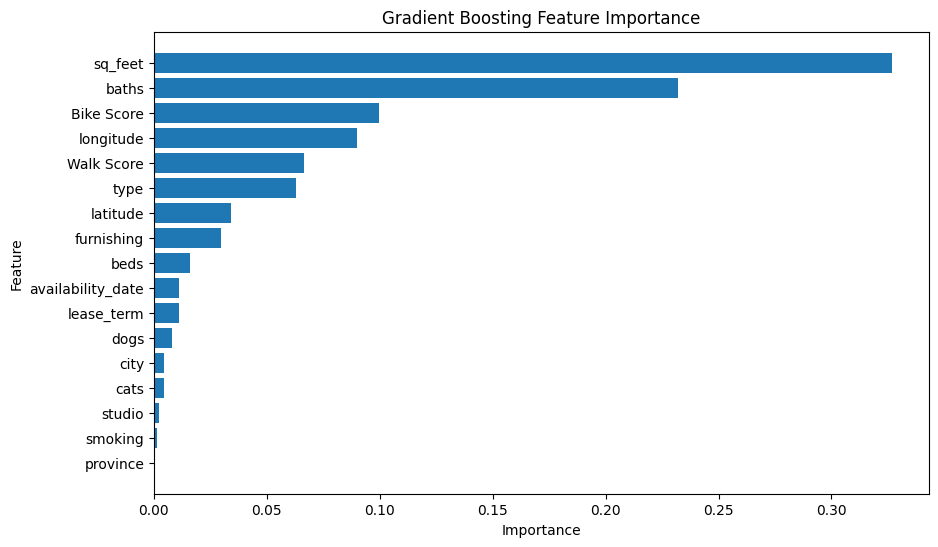

In [ ]:

importances = gb_model.feature_importances_


gb_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


print(gb_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(gb_importance_df['Feature'], gb_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## **Neural Network**

In [ ]:
import numpy as np

def clean_data(X, y):
    
    X = np.nan_to_num(X)  
    y = np.nan_to_num(y)
    return X, y

X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error

import numpy as np


def clean_data(X, y):
    
    X = np.nan_to_num(X)  
    y = np.nan_to_num(y)
    return X, y

X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)


print(f"X_train contains NaN: {np.isnan(X_train).any()}")
print(f"y_train contains NaN: {np.isnan(y_train).any()}")


nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  
    Dropout(0.3),  
    Dense(64, activation='relu'),  
    Dropout(0.3),  
    Dense(32, activation='relu'),  
    Dense(1)  
])


nn_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mae',
                 metrics=['mae'])


history = nn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


nn_test_loss, nn_test_mape = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Neural Network Test Loss (MAPE): {nn_test_loss:.2f}%")
print(f"Neural Network Test MAPE: {nn_test_mape:.2f}%")


y_pred = nn_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


X_train contains NaN: False
y_train contains NaN: False
Epoch 1/50
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 739.0927 - mae: 739.0927 - val_loss: 273.4688 - val_mae: 273.4688
Epoch 2/50
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 346.7405 - mae: 346.7405 - val_loss: 261.5642 - val_mae: 261.5642
Epoch 3/50
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 338.2685 - mae: 338.2685 - val_loss: 261.7242 - val_mae: 261.7242
Epoch 4/50
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 338.2104 - mae: 338.2104 - val_loss: 262.9135 - val_mae: 262.9135
Epoch 5/50
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 328.3665 - mae: 328.3665 - val_loss: 253.3024 - val_mae: 253.3024
Epoch 6/50
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 326.9091 - mae: 326.9091 - val_loss: 255.7246 - val_mae: 255.7246
Epoch 7/50
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 323.9562 - mae: 323.9562 - val_loss: 258.0616 - val_mae: 258.0616
Epoch 8/50
2722/2722 ━━━━━━━━━━━━━━━━━━━━ 11s

In [ ]:
y_pred_nn = nn_model.predict(X_test).flatten()

  
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print("Neural Network Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_nn:.2f}")
print(f"Mean Squared Error (MSE): {mse_nn:.2f}")
print(f"R² Score: {r2_nn:.2f}")


851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neural Network Evaluation Metrics:
Mean Absolute Error (MAE): 350.49
Mean Squared Error (MSE): 261372.39
R² Score: 0.68


## **Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


print("Random Forest Regression Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

Random Forest Regression Evaluation Metrics:
Mean Absolute Error (MAE): 47.36
Mean Squared Error (MSE): 15719.71
R² Score: 0.98


              Feature  Importance
8             sq_feet    0.318423
7               baths    0.246204
15         Bike Score    0.089193
3           longitude    0.089003
14         Walk Score    0.062682
5                type    0.049730
2            latitude    0.048301
9          furnishing    0.026005
6                beds    0.020492
10  availability_date    0.015931
4          lease_term    0.011817
12               cats    0.006549
0                city    0.006284
11            smoking    0.003660
13               dogs    0.003632
16             studio    0.001794
1            province    0.000301


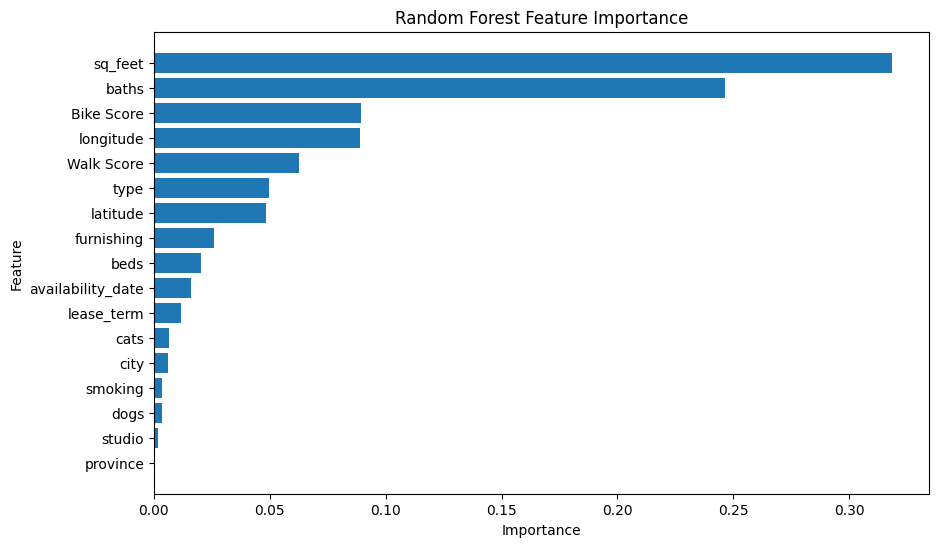

In [ ]:

importances = rf_model.feature_importances_


rf_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


print(rf_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


# **Comparison**

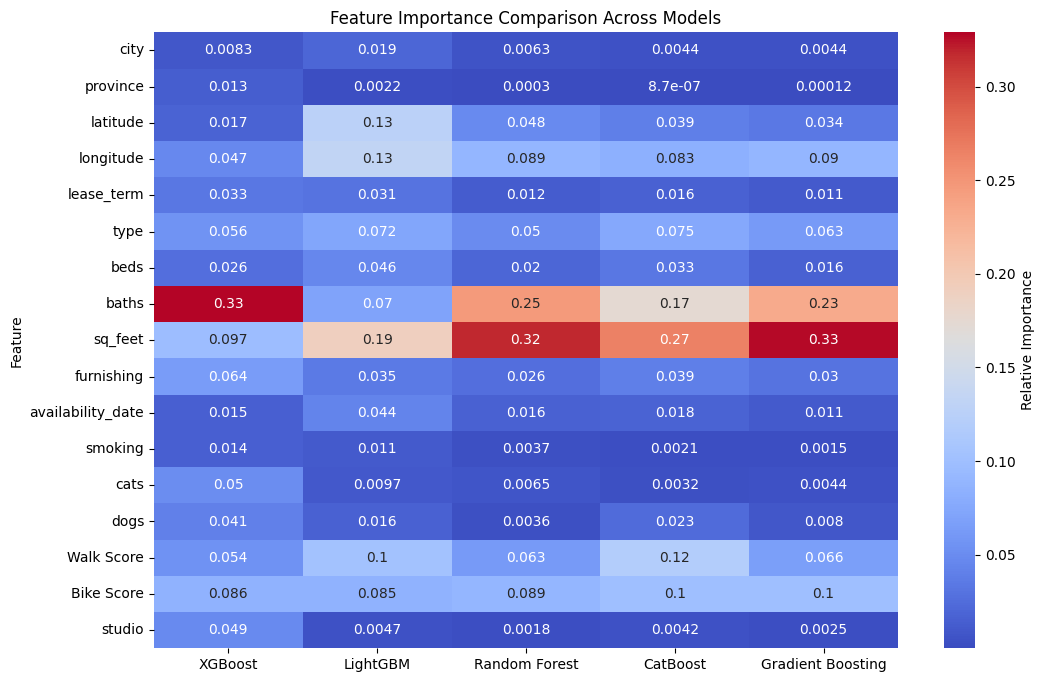

In [ ]:

combined_importance_df = pd.DataFrame({
    'Feature': features,
    'XGBoost': xgb_model.feature_importances_,
    'LightGBM': lgbm_model.feature_importances_,
    'Random Forest': rf_model.feature_importances_,
    'CatBoost': catboost_model.get_feature_importance(),
    'Gradient Boosting': gb_model.feature_importances_
}).set_index('Feature')


combined_importance_df = combined_importance_df.div(combined_importance_df.sum(axis=0), axis=1)


plt.figure(figsize=(12, 8))
sns.heatmap(combined_importance_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'Relative Importance'})
plt.title("Feature Importance Comparison Across Models")
plt.show()


851/851 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


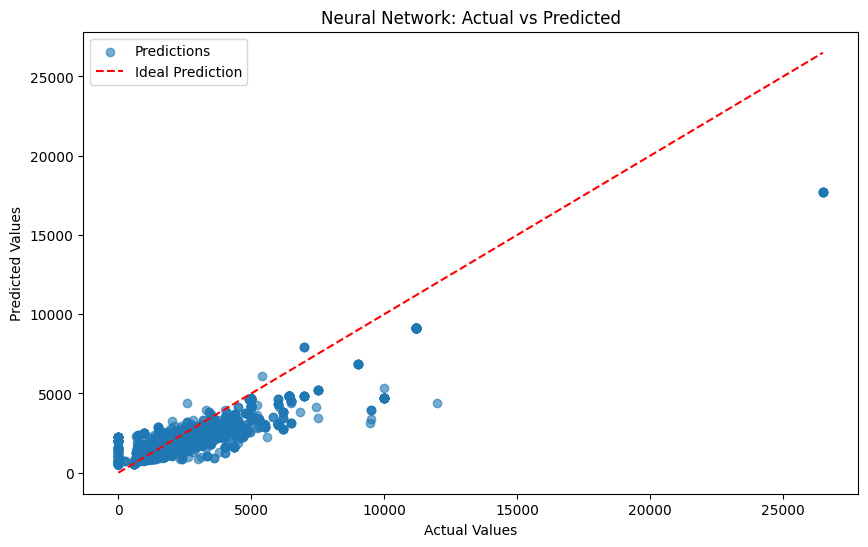

In [ ]:
import matplotlib.pyplot as plt


def visualize_metrics(y_test, y_pred, model_name="Model"):
    """
    

    Parameters:
    - y_test: Actual target values.
    - y_pred: Predicted target values.
    - model_name: Name of the model (for titles).
    """
    # Plot True vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label="Predictions")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Ideal Prediction")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.legend()
    plt.show()




y_pred_nn = nn_model.predict(X_test).flatten()  # Flatten for compatibility


visualize_metrics(y_test, y_pred_nn, model_name="Neural Network")


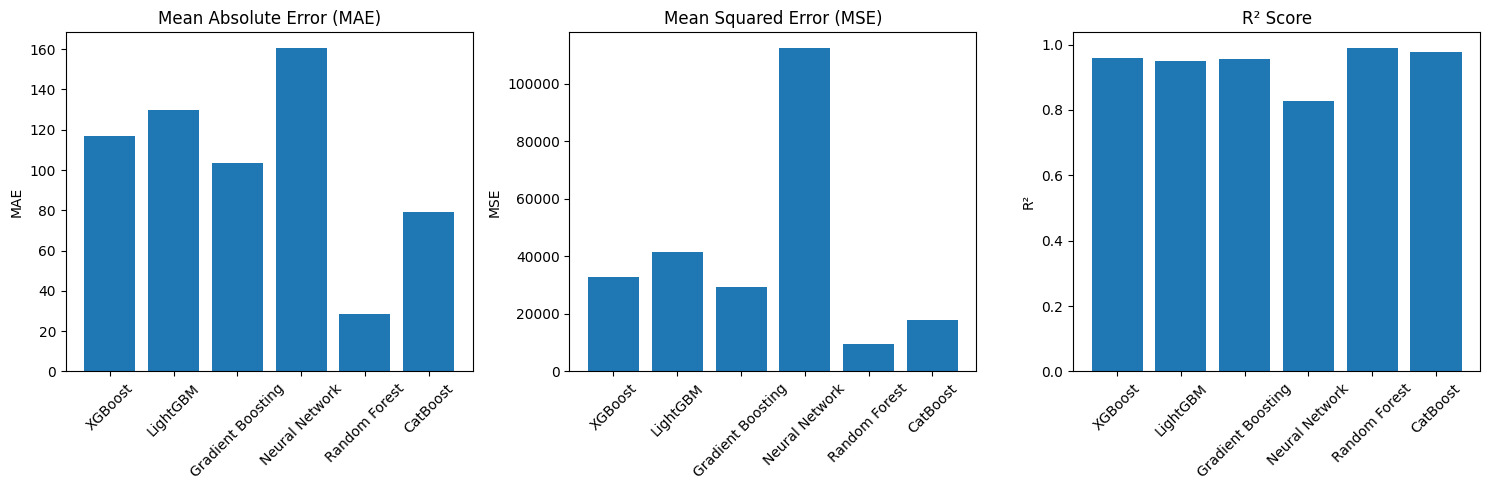

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


metrics = {
    "Model": ["XGBoost", "LightGBM", "Gradient Boosting","Neural Network", "Random Forest","CatBoost"],
    "MAE": [mae_xgb, mae_lgbm, mae_gb, mae_nn, mae_rf,mae_catboost],
    "MSE": [mse_xgb, mse_lgbm, mse_gb, mse_nn, mse_rf,mse_catboost],
    "R²": [r2_xgb, r2_lgbm, r2_gb, r2_nn, r2_rf,r2_catboost]
}


metrics_df = pd.DataFrame(metrics)


plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.bar(metrics["Model"], metrics["MAE"])
plt.title("Mean Absolute Error (MAE)")
plt.ylabel("MAE")
plt.xticks(rotation=45)


plt.subplot(1, 3, 2)
plt.bar(metrics["Model"], metrics["MSE"])
plt.title("Mean Squared Error (MSE)")
plt.ylabel("MSE")
plt.xticks(rotation=45)


plt.subplot(1, 3, 3)
plt.bar(metrics["Model"], metrics["R²"])
plt.title("R² Score")
plt.ylabel("R²")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
metrics_df

NameError: name 'metrics_df' is not defined

# **Prediction**

### **House-1**

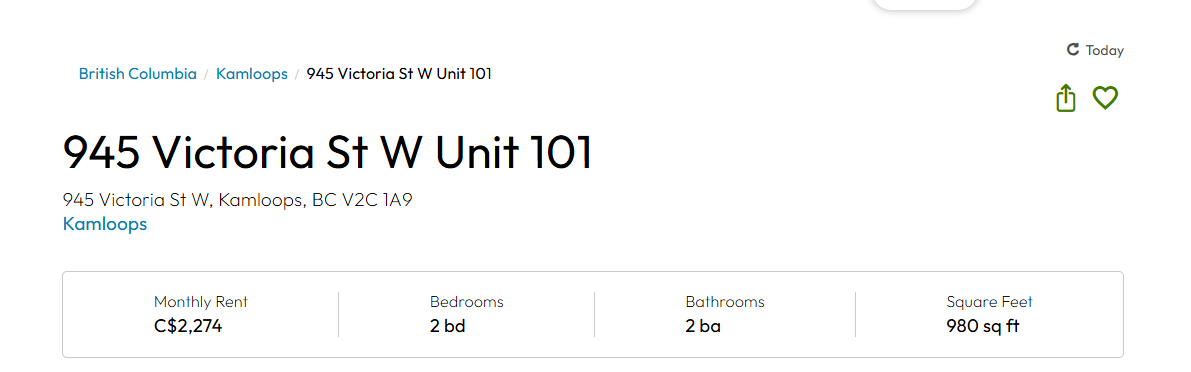

https://www.apartments.com/945-victoria-st-w-kamloops-bc-unit-101/qzlftlx/

In [ ]:
# Function to preprocess unseen data
def preprocess_unseen_data(unseen_data, feature_columns, encoders, scaler):
    """
    
    """
    
    unseen_df = pd.DataFrame([unseen_data])

    for col in encoders:
        if col in unseen_df.columns:
            unseen_df[col] = encoders[col].transform(unseen_df[col])

    
    for col in feature_columns:
        if col not in unseen_df.columns:
            unseen_df[col] = 0  

    
    scaled_data = scaler.transform(unseen_df[feature_columns])

    return scaled_data


unseen_data = {
    'city': 'kamloops',  
    'province': 'british columbia',  
    'latitude': 50.670143906487,  
    'longitude': -120.22682388089,  
    'lease_term': 'long term',  
    'type': 'apartment',  
    'beds': 2,  
    'baths': 2,  
    'sq_feet': 980 ,  
    'furnishing': 'furnished',  
    'availability_date': 'immediate',  
    'smoking': 'non-smoking',  
    'cats': 1,  
    'dogs': 1,  
    'Walk Score': 24,
    'Bike Score': 14,
    'studio': 0  
}


encoded_data = preprocess_unseen_data(
    unseen_data,
    feature_columns=features,
    encoders=label_encoders,
    scaler=scaler
)


predictions = {

    "Random Forest": rf_model.predict(encoded_data)[0]}


for model_name, prediction in predictions.items():
    print(f"{model_name} Predicted Price: ${prediction:.2f}")


Random Forest Predicted Price: $2141.53


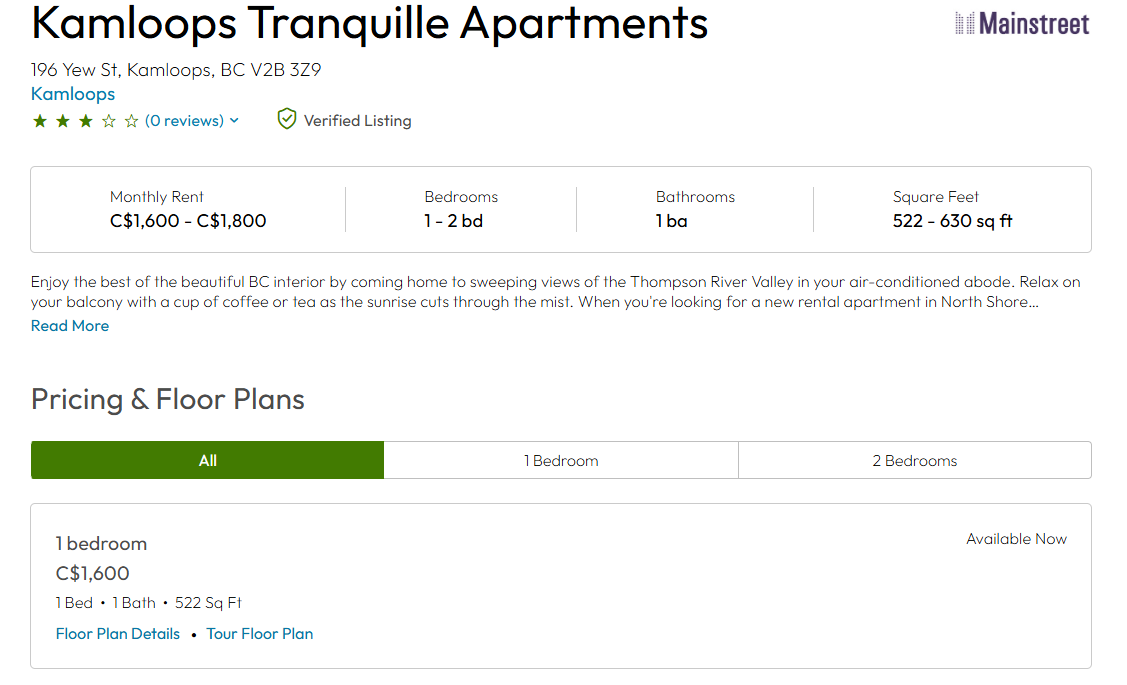

https://www.apartments.com/kamloops-tranquille-apartments-kamloops-bc/gq98g5z/

**We got a close prediction in random forest model**

In [ ]:

def preprocess_unseen_data(unseen_data, feature_columns, encoders, scaler):
    """
    
    """
    
    unseen_df = pd.DataFrame([unseen_data])

    
    for col in encoders:
        if col in unseen_df.columns:
            unseen_df[col] = encoders[col].transform(unseen_df[col])

    
    for col in feature_columns:
        if col not in unseen_df.columns:
            unseen_df[col] = 0  

    
    scaled_data = scaler.transform(unseen_df[feature_columns])

    return scaled_data


unseen_data = {
    'city': 'kamloops',  
    'province': 'british columbia',  
    'latitude': 50.670143906487,  
    'longitude': -120.22682388089,  
    'lease_term': 'long term',  
    'type': 'apartment',  
    'beds': 1,  
    'baths': 1,  
    'sq_feet': 522 ,  
    'furnishing': 'unfurnished',  
    'availability_date': 'immediate',  
    'smoking': 'non-smoking',  
    'cats': 1,  
    'dogs': 1,  
    'Walk Score': 89,  
    'Bike Score': 68,  
    'studio': 0  
}


encoded_data = preprocess_unseen_data(
    unseen_data,
    feature_columns=features,
    encoders=label_encoders,
    scaler=scaler
)


predictions = {

    "Random Forest": rf_model.predict(encoded_data)[0]}


for model_name, prediction in predictions.items():
    print(f"{model_name} Predicted Price: ${prediction:.2f}")


Random Forest Predicted Price: $1633.34


In [ ]:
unseen_data = {
    'city': 'kamloops', 
    'province': 'british columbia',  
    'latitude': 50.670143906487,  
    'longitude': -120.22682388089,  
    'lease_term': 'long term', 
    'type': 'apartment',  
    'beds': [1,2],  
    'baths': 1,  
    'sq_feet': [522,620] , 
    'furnishing': 'unfurnished',  
    'availability_date': 'immediate',  
    'smoking': 'non-smoking',  
    'cats': 1,  
    'dogs': 1,  
    'Walk Score': 89,  
    'Bike Score': 68,  
    'studio': 0  
}

# **House Price Analysis**

In [1]:
import pandas as pd
file_path = "/content/Seasonally Adjusted.xlsx"
sheets_data = pd.read_excel(file_path, sheet_name=None)

existing_sheets = [
    'AGGREGATE', 'BRITISH_COLUMBIA', 'VANCOUVER_ISLAND', 'VICTORIA',
    'LOWER_MAINLAND', 'GREATER_VANCOUVER', 'FRASER_VALLEY',
    'CHILLIWACK_AND_DISTRICT', 'INTERIOR_BC', 'ALBERTA', 'CALGARY',
    'EDMONTON', 'SASKATCHEWAN', 'REGINA', 'SASKATOON', 'WINNIPEG',
    'ONTARIO', 'BANCROFT_AND_AREA', 'BARRIE_AND_DISTRICT',
    'BRANTFORD_REGION', 'CAMBRIDGE', 'GREY_BRUCE_OWEN_SOUND',
    'GUELPH_AND_DISTRICT', 'HAMILTON_BURLINGTON', 'HURON_PERTH',
    'KAWARTHA_LAKES', 'KINGSTON_AND_AREA', 'KITCHENER_WATERLOO',
    'LAKELANDS', 'LONDON_ST_THOMAS', 'MISSISSAUGA', 'NIAGARA_REGION',
    'NORTH_BAY', 'NORTHUMBERLAND_HILLS', 'OAKVILLE_MILTON', 'OTTAWA',
    'PETERBOROUGH_AND_KAWARTHAS', 'QUINTE_AND_DISTRICT',
    'RIDEAU_ST_LAWRENCE', 'SAULT_STE_MARIE', 'SIMCOE_AND_DISTRICT',
    'TILLSONBURG_DISTRICT', 'GREATER_TORONTO', 'WINDSOR_ESSEX',
    'WOODSTOCK_INGERSOLL', 'QUEBEC', 'CENTRE_DU_QUEBEC', 'ESTRIE',
    'MAURICIE', 'MONTREAL_CMA', 'QUEBEC_CMA', 'NEW_BRUNSWICK',
    'FREDERICTON', 'GREATER_MONCTON', 'SAINT_JOHN_NB', 'NOVA_SCOTIA',
    'HALIFAX_DARTMOUTH', 'PRINCE_EDWARD_ISLAND',
    'NEWFOUNDLAND_AND_LABRADOR', 'ST_JOHNS_NL'
]


sheet_to_city_mapping = {
    'VANCOUVER_ISLAND': 'Vancouver',
    'VICTORIA': 'Victoria',
    'LOWER_MAINLAND': 'Vancouver',
    'GREATER_VANCOUVER': 'Vancouver',
    'FRASER_VALLEY': 'Abbotsford',
    'CHILLIWACK_AND_DISTRICT': 'Chilliwack',
    'INTERIOR_BC': 'Kamloops',
    'ALBERTA': 'Edmonton',
    'CALGARY': 'Calgary',
    'EDMONTON': 'Edmonton',
    'SASKATCHEWAN': 'Regina',
    'REGINA': 'Regina',
    'SASKATOON': 'Saskatoon',
    'WINNIPEG': 'Winnipeg',
    'ONTARIO': 'Toronto',
    'BANCROFT_AND_AREA': 'Bancroft',
    'BARRIE_AND_DISTRICT': 'Barrie',
    'BRANTFORD_REGION': 'Brantford',
    'CAMBRIDGE': 'Cambridge',
    'GREY_BRUCE_OWEN_SOUND': 'Owen Sound',
    'GUELPH_AND_DISTRICT': 'Guelph',
    'HAMILTON_BURLINGTON': 'Hamilton',
    'HURON_PERTH': 'Stratford',
    'KAWARTHA_LAKES': 'Lindsay',
    'KINGSTON_AND_AREA': 'Kingston',
    'KITCHENER_WATERLOO': 'Kitchener',
    'LAKELANDS': 'Muskoka',
    'LONDON_ST_THOMAS': 'London',
    'MISSISSAUGA': 'Mississauga',
    'NIAGARA_REGION': 'Niagara Falls',
    'NORTH_BAY': 'North Bay',
    'NORTHUMBERLAND_HILLS': 'Cobourg',
    'OAKVILLE_MILTON': 'Oakville',
    'OTTAWA': 'Ottawa',
    'PETERBOROUGH_AND_KAWARTHAS': 'Peterborough',
    'QUINTE_AND_DISTRICT': 'Belleville',
    'RIDEAU_ST_LAWRENCE': 'Brockville',
    'SAULT_STE_MARIE': 'Sault Ste. Marie',
    'SIMCOE_AND_DISTRICT': 'Simcoe',
    'TILLSONBURG_DISTRICT': 'Tillsonburg',
    'GREATER_TORONTO': 'Toronto',
    'WINDSOR_ESSEX': 'Windsor',
    'WOODSTOCK_INGERSOLL': 'Woodstock',
    'QUEBEC': 'Quebec City',
    'CENTRE_DU_QUEBEC': 'Drummondville',
    'ESTRIE': 'Sherbrooke',
    'MAURICIE': 'Trois-Rivières',
    'MONTREAL_CMA': 'Montreal',
    'QUEBEC_CMA': 'Quebec City',
    'NEW_BRUNSWICK': 'Fredericton',
    'FREDERICTON': 'Fredericton',
    'GREATER_MONCTON': 'Moncton',
    'SAINT_JOHN_NB': 'Saint John',
    'NOVA_SCOTIA': 'Halifax',
    'HALIFAX_DARTMOUTH': 'Halifax',
    'PRINCE_EDWARD_ISLAND': 'Charlottetown',
    'NEWFOUNDLAND_AND_LABRADOR': "St. John's",
    'ST_JOHNS_NL': "St. John's"
}


renamed_sheets = {sheet_name: sheet_to_city_mapping.get(sheet_name, sheet_name) for sheet_name in existing_sheets}


for old_name, new_name in renamed_sheets.items():
    print(f"{old_name} -> {new_name}")


AGGREGATE -> AGGREGATE
BRITISH_COLUMBIA -> BRITISH_COLUMBIA
VANCOUVER_ISLAND -> Vancouver
VICTORIA -> Victoria
LOWER_MAINLAND -> Vancouver
GREATER_VANCOUVER -> Vancouver
FRASER_VALLEY -> Abbotsford
CHILLIWACK_AND_DISTRICT -> Chilliwack
INTERIOR_BC -> Kamloops
ALBERTA -> Edmonton
CALGARY -> Calgary
EDMONTON -> Edmonton
SASKATCHEWAN -> Regina
REGINA -> Regina
SASKATOON -> Saskatoon
WINNIPEG -> Winnipeg
ONTARIO -> Toronto
BANCROFT_AND_AREA -> Bancroft
BARRIE_AND_DISTRICT -> Barrie
BRANTFORD_REGION -> Brantford
CAMBRIDGE -> Cambridge
GREY_BRUCE_OWEN_SOUND -> Owen Sound
GUELPH_AND_DISTRICT -> Guelph
HAMILTON_BURLINGTON -> Hamilton
HURON_PERTH -> Stratford
KAWARTHA_LAKES -> Lindsay
KINGSTON_AND_AREA -> Kingston
KITCHENER_WATERLOO -> Kitchener
LAKELANDS -> Muskoka
LONDON_ST_THOMAS -> London
MISSISSAUGA -> Mississauga
NIAGARA_REGION -> Niagara Falls
NORTH_BAY -> North Bay
NORTHUMBERLAND_HILLS -> Cobourg
OAKVILLE_MILTON -> Oakville
OTTAWA -> Ottawa
PETERBOROUGH_AND_KAWARTHAS -> Peterborough
QUI

In [3]:
for sheet_name, df in sheets_data.items():
    rows, cols = df.shape
    print(f"Sheet: {sheet_name} -> Rows: {rows}, Columns: {cols}")

Sheet: AGGREGATE -> Rows: 238, Columns: 13
Sheet: BRITISH_COLUMBIA -> Rows: 238, Columns: 13
Sheet: VANCOUVER_ISLAND -> Rows: 238, Columns: 13
Sheet: VICTORIA -> Rows: 238, Columns: 13
Sheet: LOWER_MAINLAND -> Rows: 238, Columns: 13
Sheet: GREATER_VANCOUVER -> Rows: 238, Columns: 13
Sheet: FRASER_VALLEY -> Rows: 238, Columns: 13
Sheet: CHILLIWACK_AND_DISTRICT -> Rows: 238, Columns: 13
Sheet: INTERIOR_BC -> Rows: 238, Columns: 13
Sheet: ALBERTA -> Rows: 238, Columns: 13
Sheet: CALGARY -> Rows: 238, Columns: 13
Sheet: EDMONTON -> Rows: 238, Columns: 13
Sheet: SASKATCHEWAN -> Rows: 238, Columns: 13
Sheet: REGINA -> Rows: 238, Columns: 13
Sheet: SASKATOON -> Rows: 238, Columns: 13
Sheet: WINNIPEG -> Rows: 238, Columns: 13
Sheet: ONTARIO -> Rows: 238, Columns: 13
Sheet: BANCROFT_AND_AREA -> Rows: 238, Columns: 9
Sheet: BARRIE_AND_DISTRICT -> Rows: 238, Columns: 13
Sheet: BRANTFORD_REGION -> Rows: 238, Columns: 13
Sheet: CAMBRIDGE -> Rows: 238, Columns: 13
Sheet: GREY_BRUCE_OWEN_SOUND -> Row

In [ ]:
import pandas as pd


sheet_data=renamed_sheets

house_types_to_keep = {
    'Townhouse_Benchmark_SA': 'Townhouse',
    'Apartment_Benchmark_SA': 'Apartment',
    'Composite_Benchmark_SA': 'House'
}


for sheet_name, sheet_data in sheets_data.items():
    if 'Date' in sheet_data.columns:  
        
        matching_columns = ['Date'] + [
            col for col in sheet_data.columns if col in house_types_to_keep
        ]
        filtered_data = sheet_data[matching_columns]

        
        filtered_data = filtered_data.rename(columns=house_types_to_keep)

        
        sheets_data[sheet_name] = filtered_data


for sheet_name, sheet_data in sheets_data.items():
    print(f"Sheet: {sheet_name}")
    print(sheet_data.head())


Sheet: AGGREGATE
        Date   House  Townhouse  Apartment
0 2005-01-01  239800     201700     172000
1 2005-02-01  240500     202300     173000
2 2005-03-01  241300     202900     173900
3 2005-04-01  242000     203300     174600
4 2005-05-01  242600     203700     175400
Sheet: BRITISH_COLUMBIA
        Date   House  Townhouse  Apartment
0 2005-01-01  294100     242200     189300
1 2005-02-01  295900     243900     191200
2 2005-03-01  298100     245400     193600
3 2005-04-01  299700     246700     194900
4 2005-05-01  301600     248100     196300
Sheet: VANCOUVER_ISLAND
        Date   House  Townhouse  Apartment
0 2005-01-01  193300     136200      99400
1 2005-02-01  197400     141200     101200
2 2005-03-01  201500     145700     103200
3 2005-04-01  204600     146000     106000
4 2005-05-01  207400     146200     109200
Sheet: VICTORIA
        Date   House  Townhouse  Apartment
0 2005-01-01  301000     265400     173200
1 2005-02-01  304900     270100     176100
2 2005-03-01  30

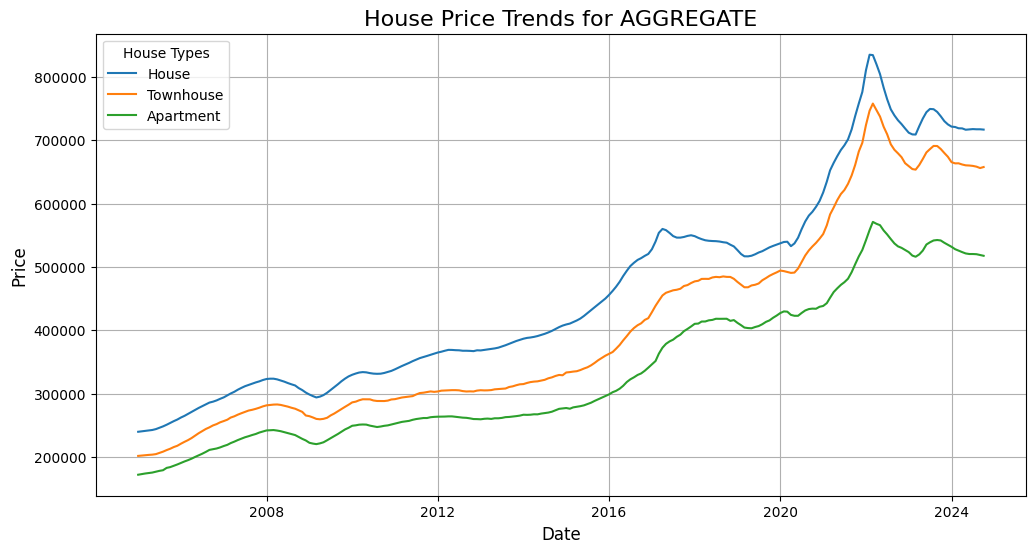

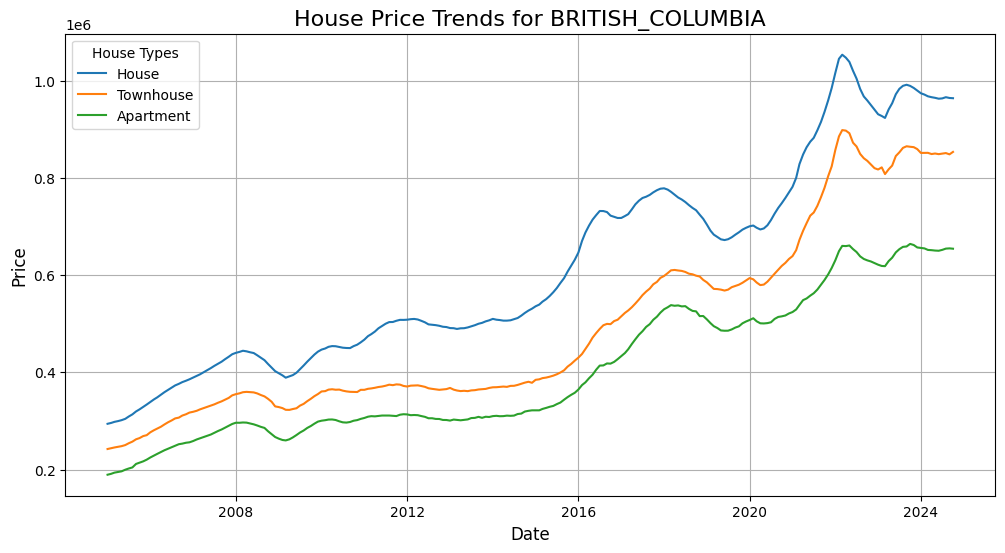

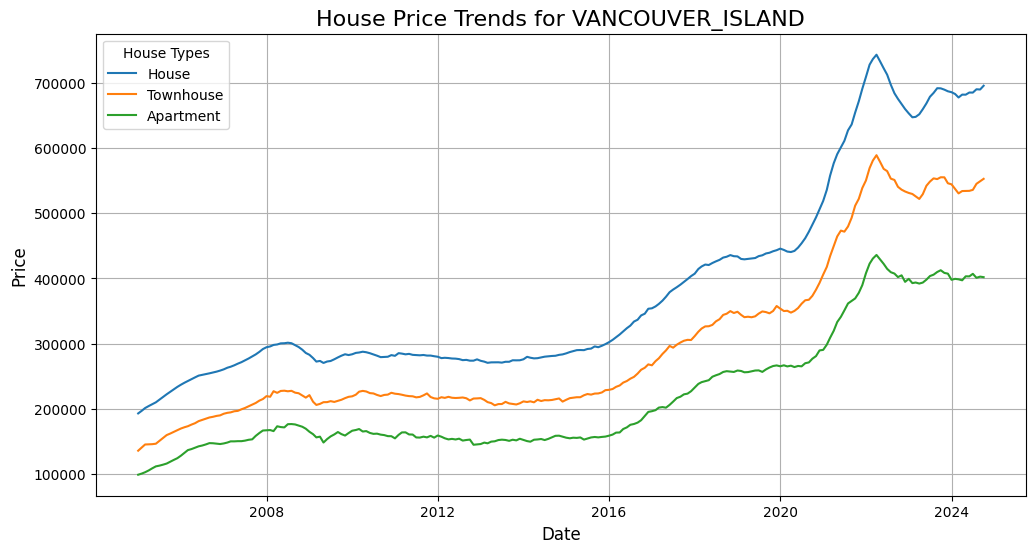

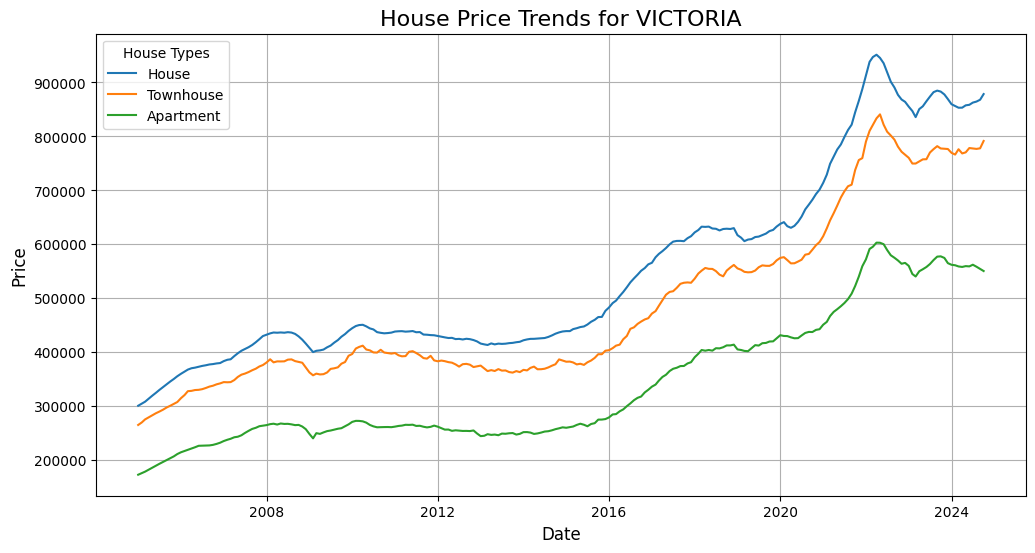

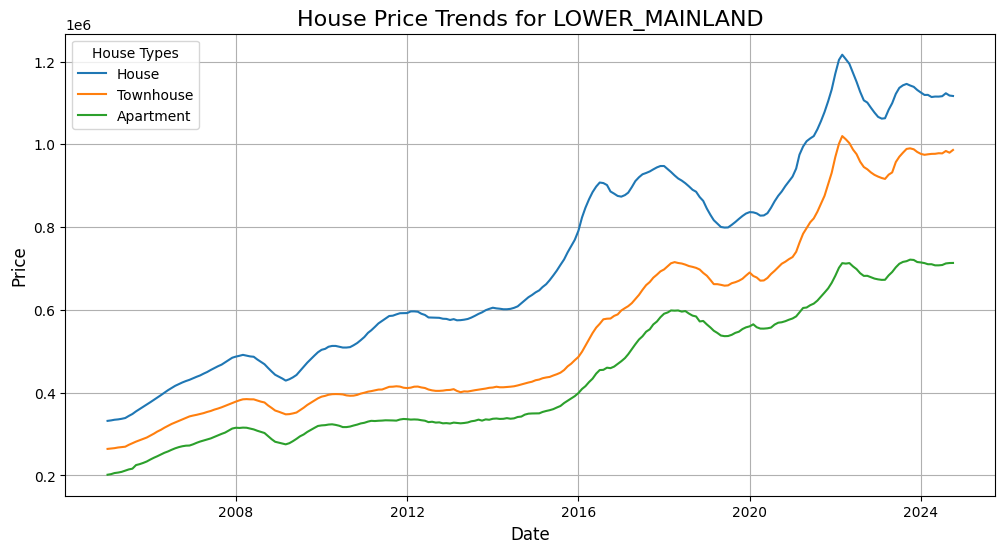

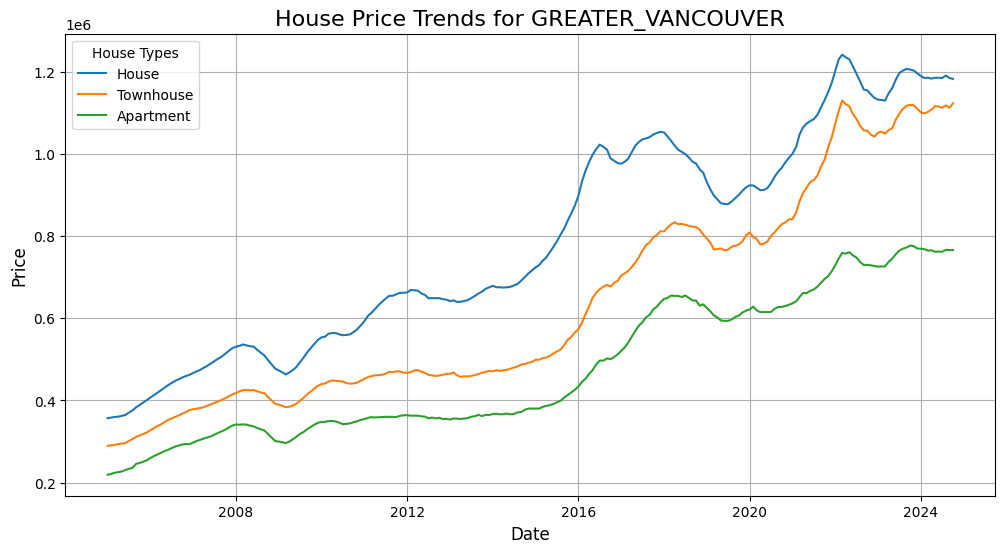

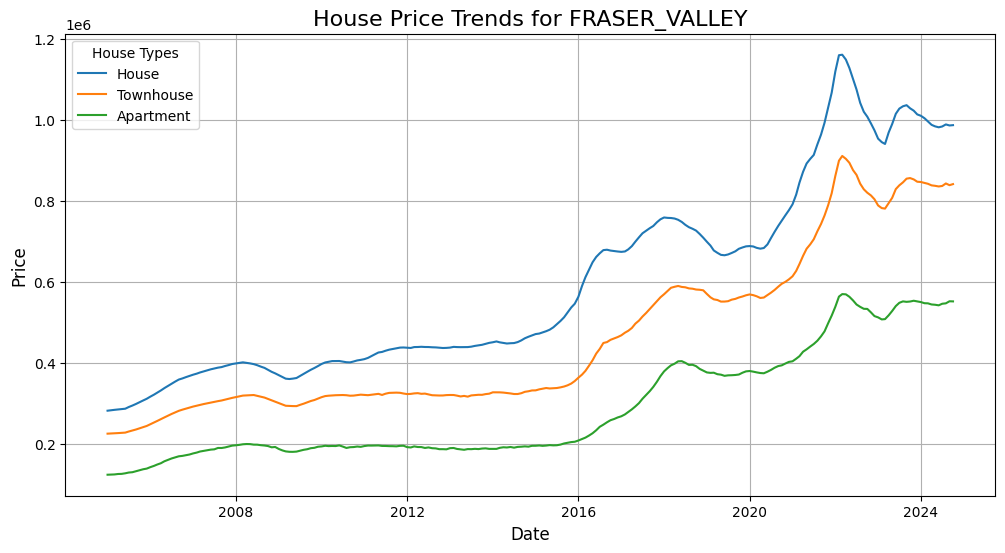

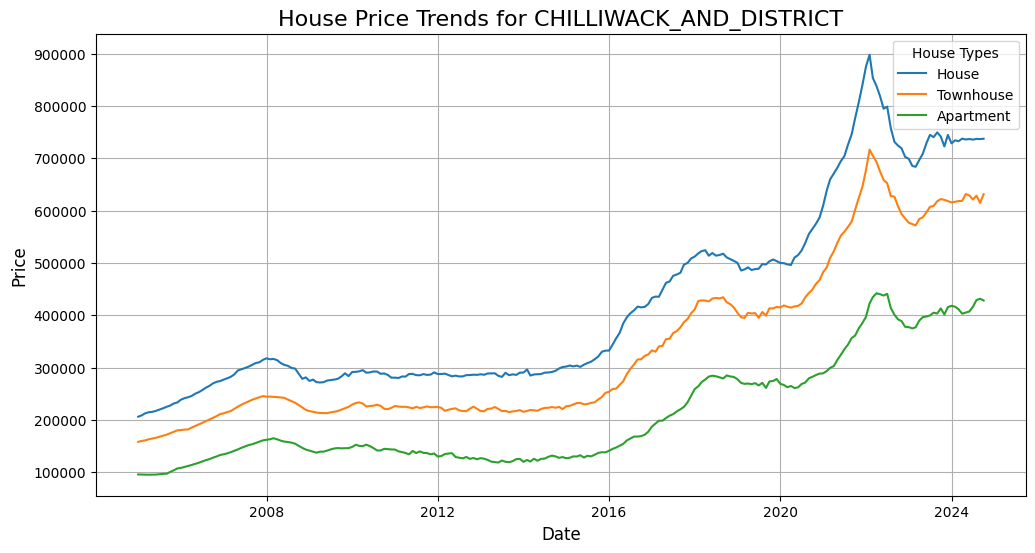

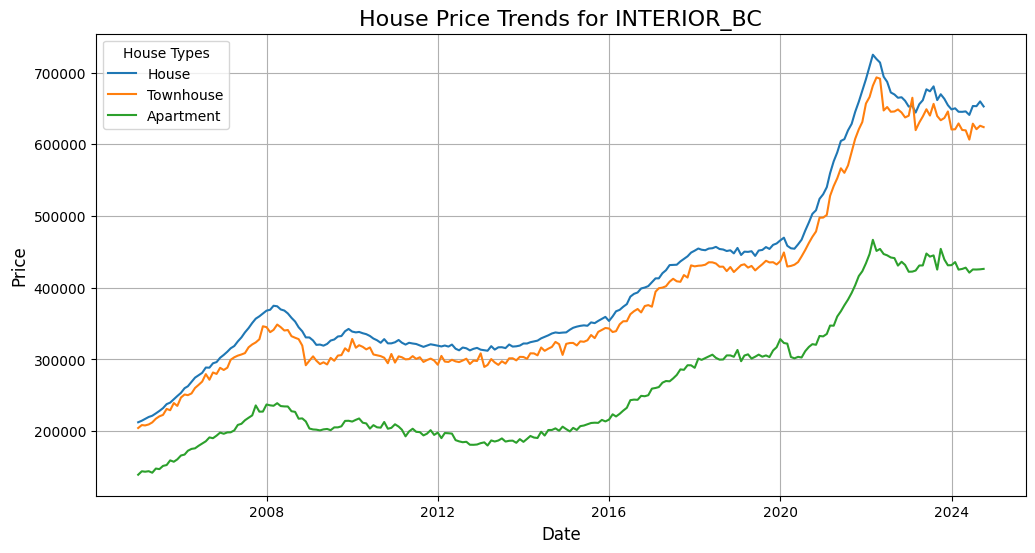

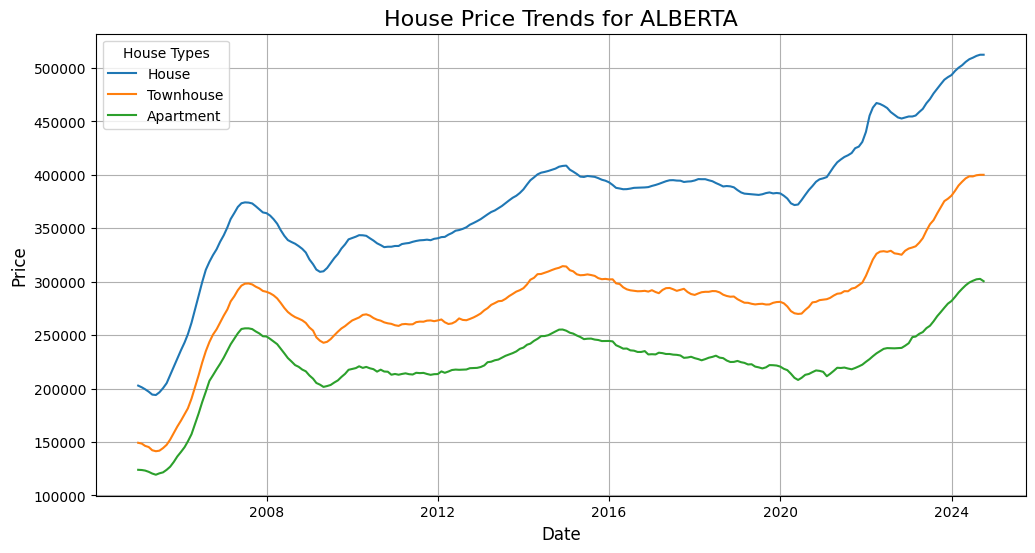

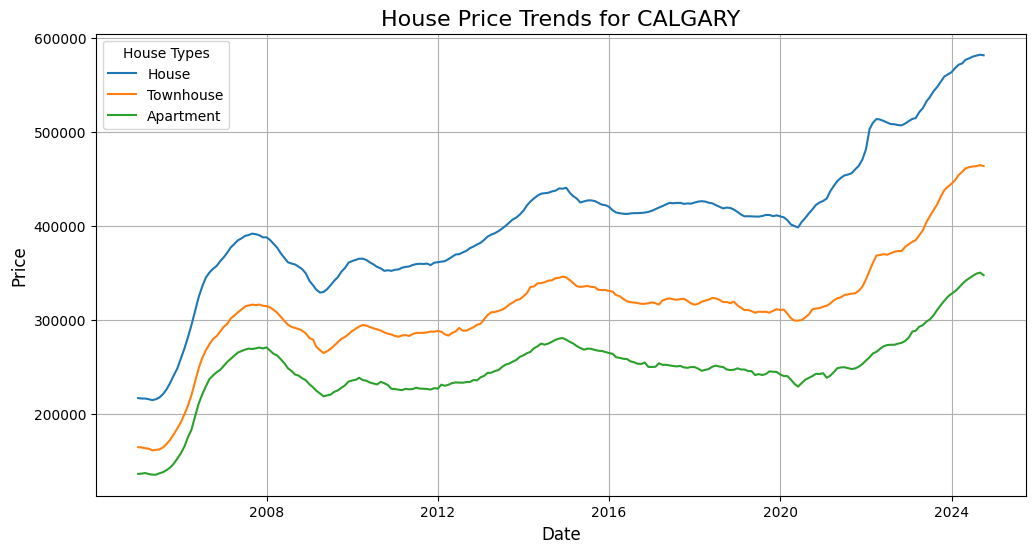

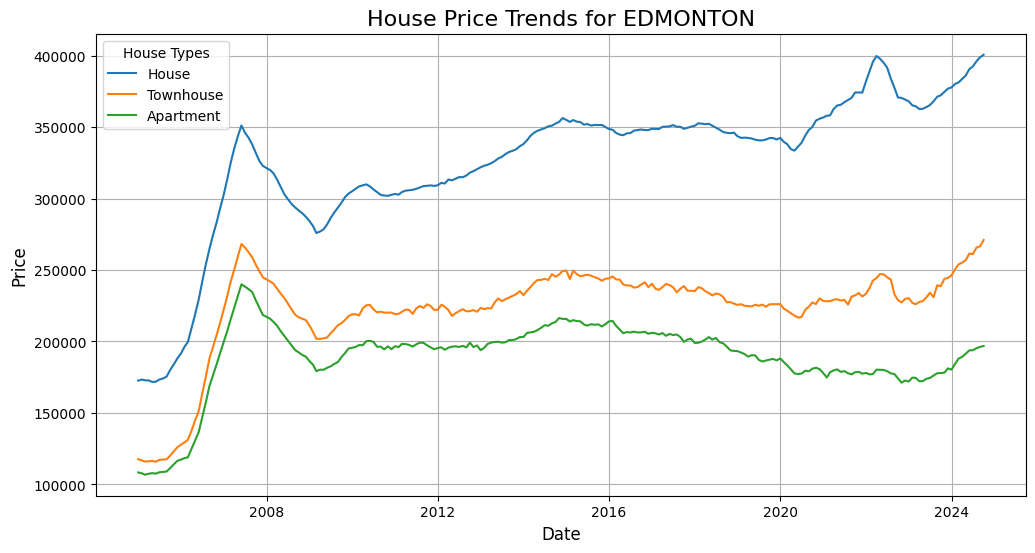

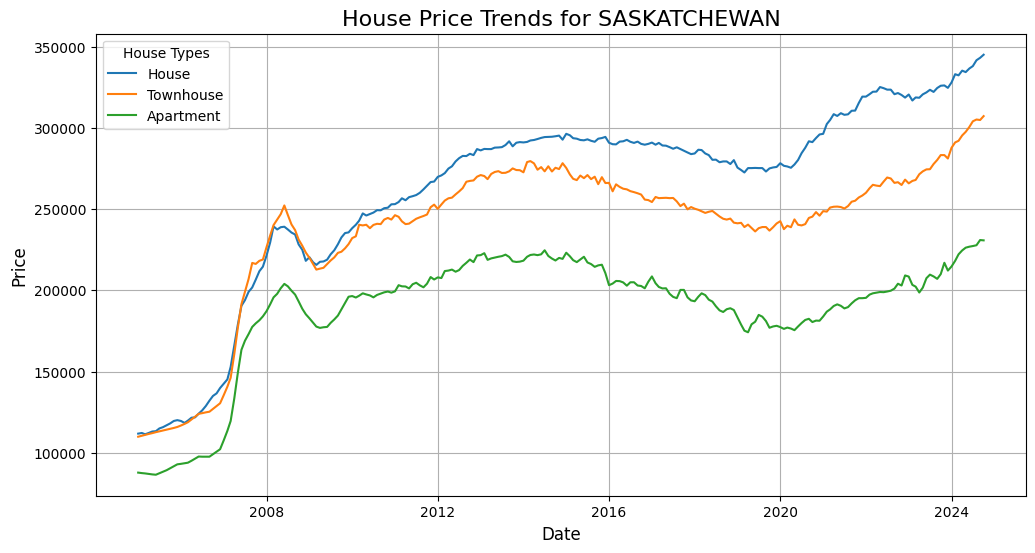

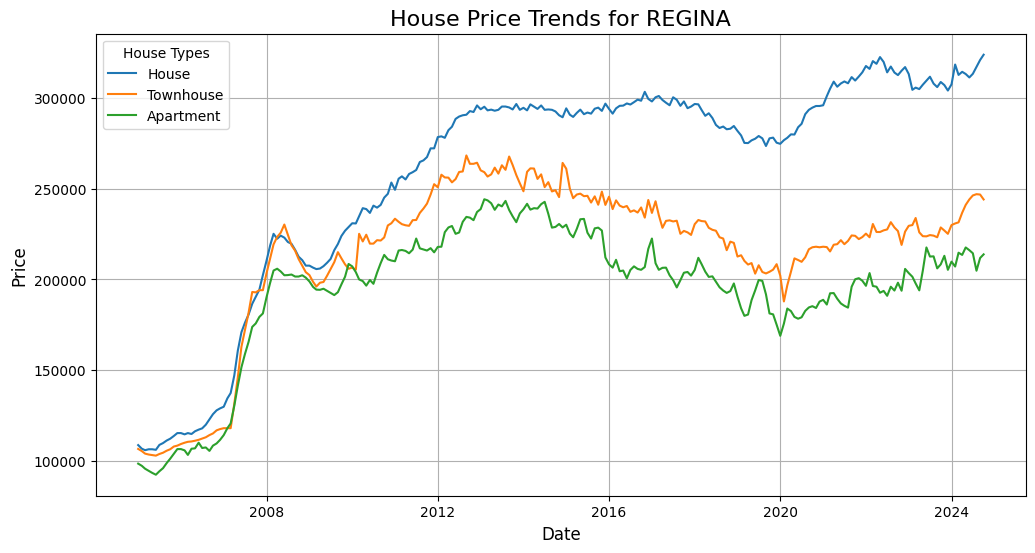

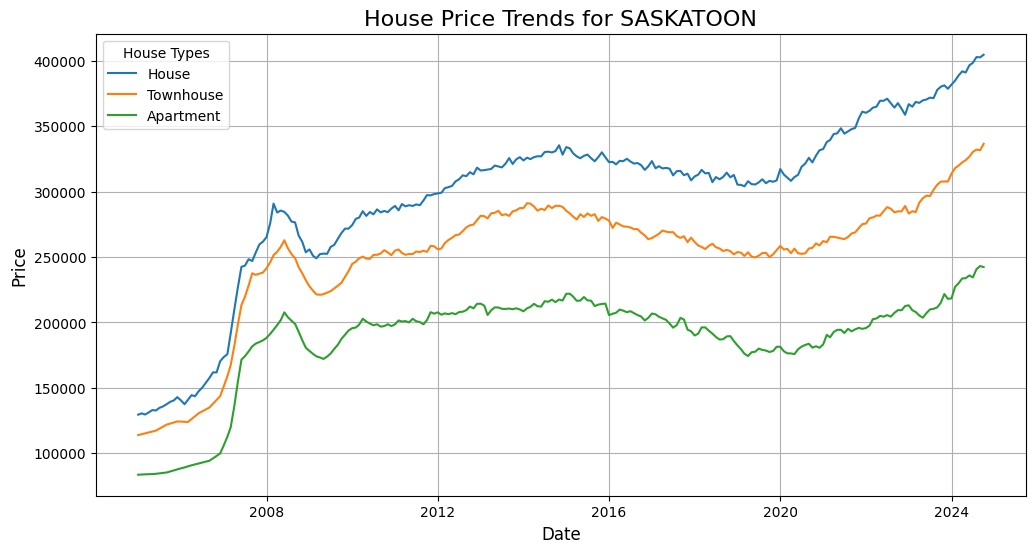

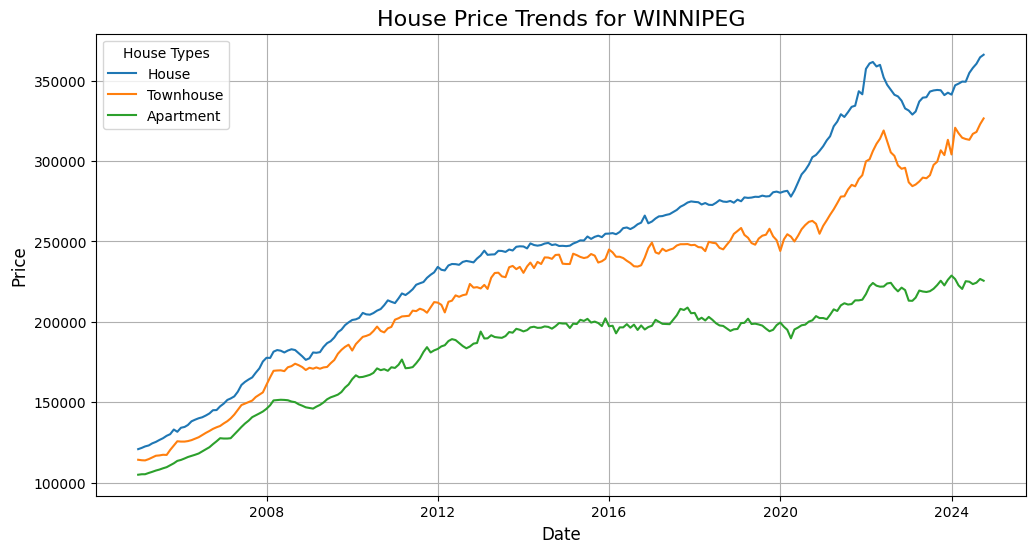

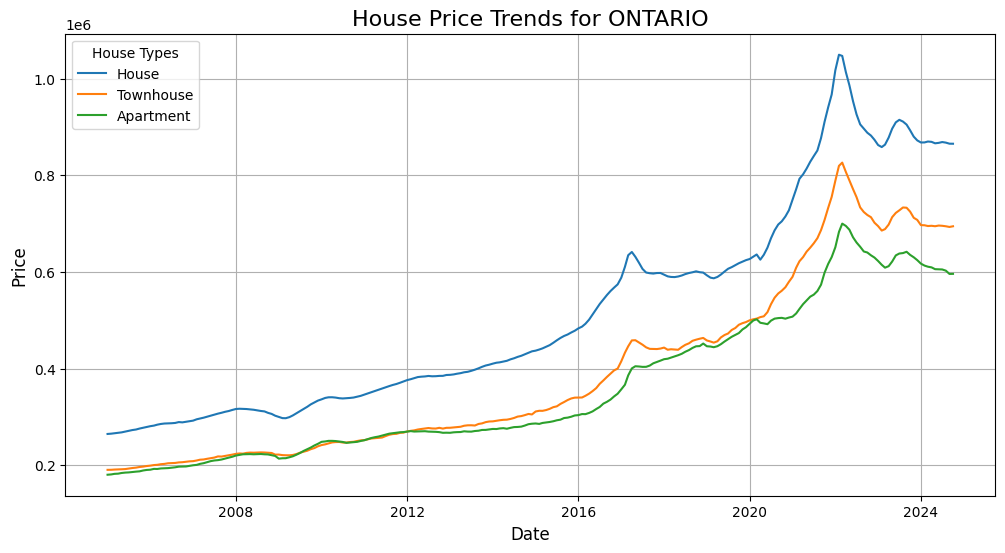

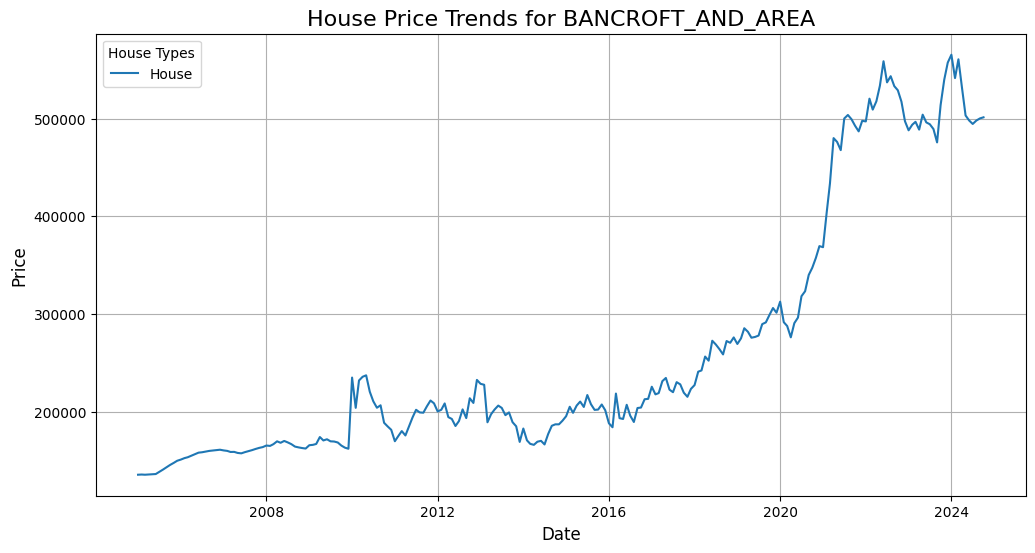

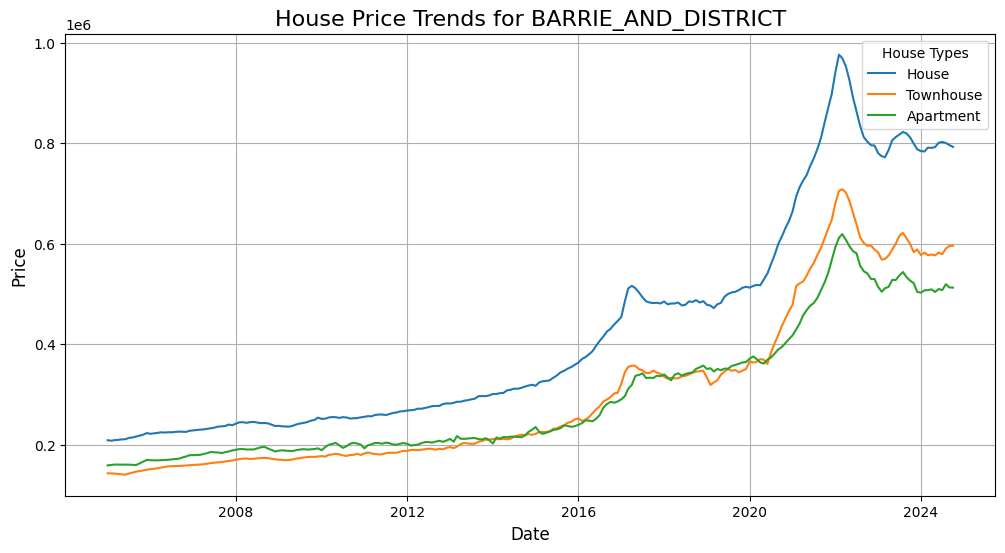

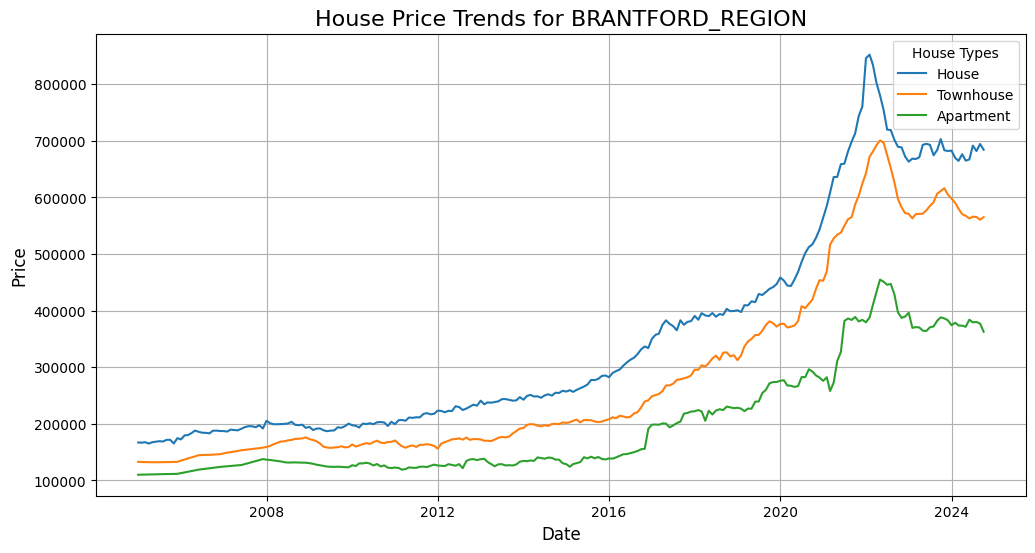

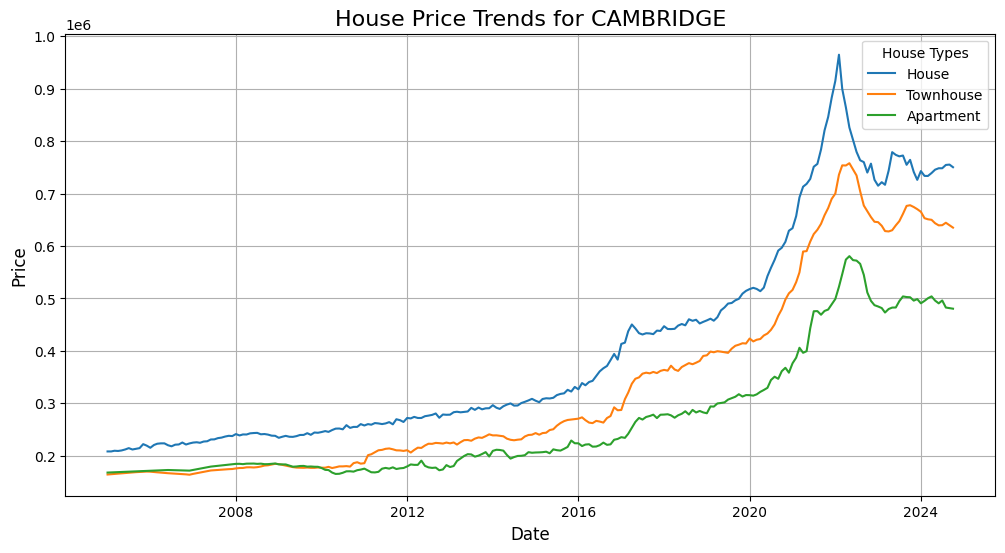

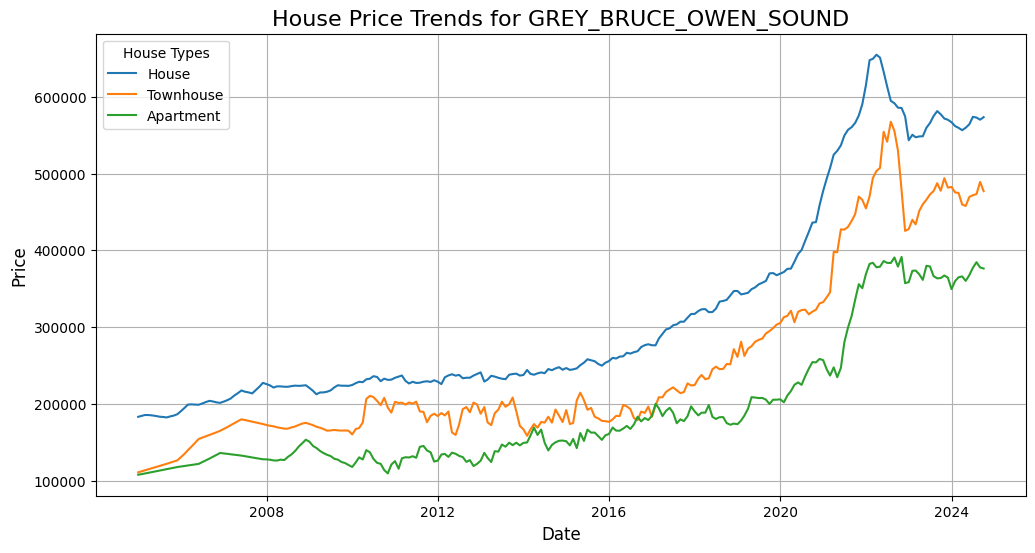

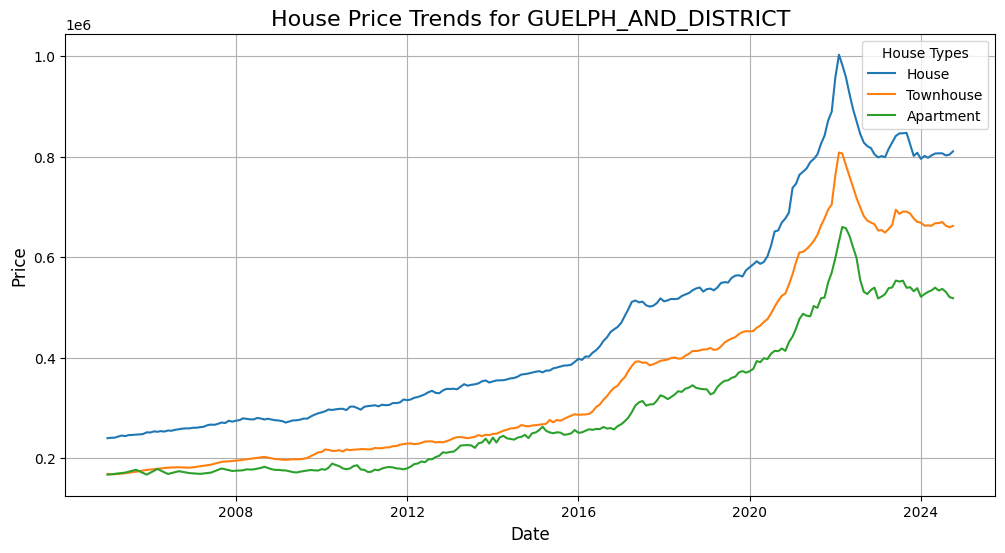

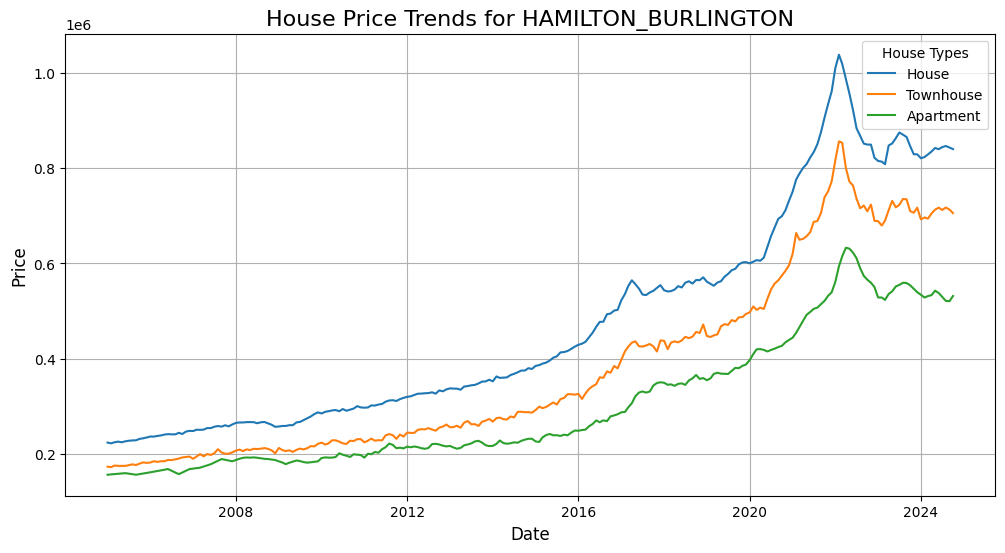

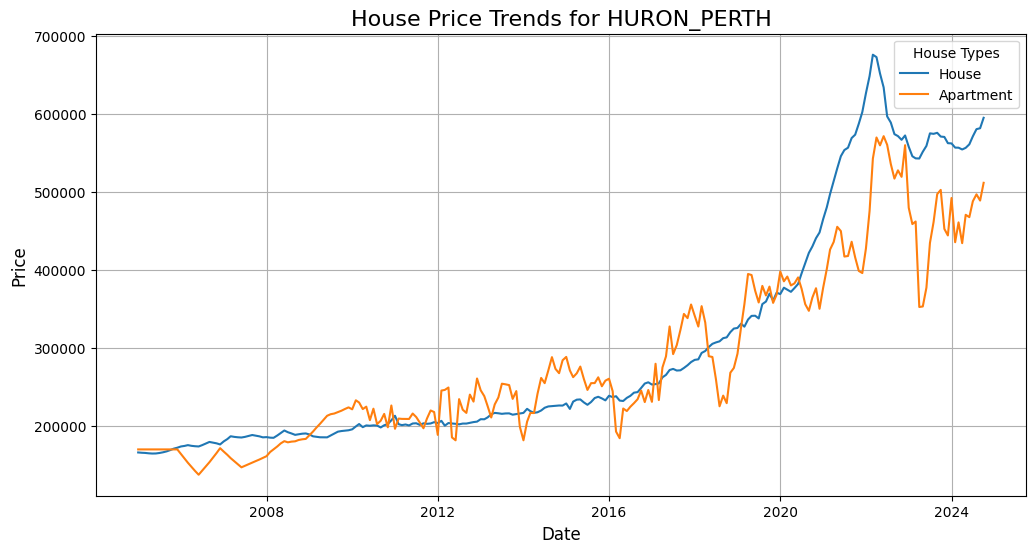

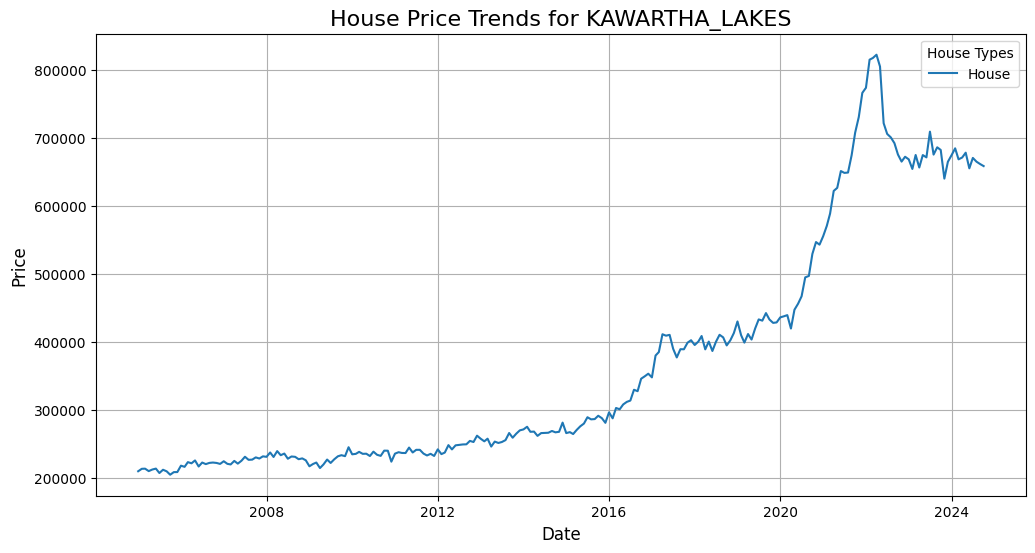

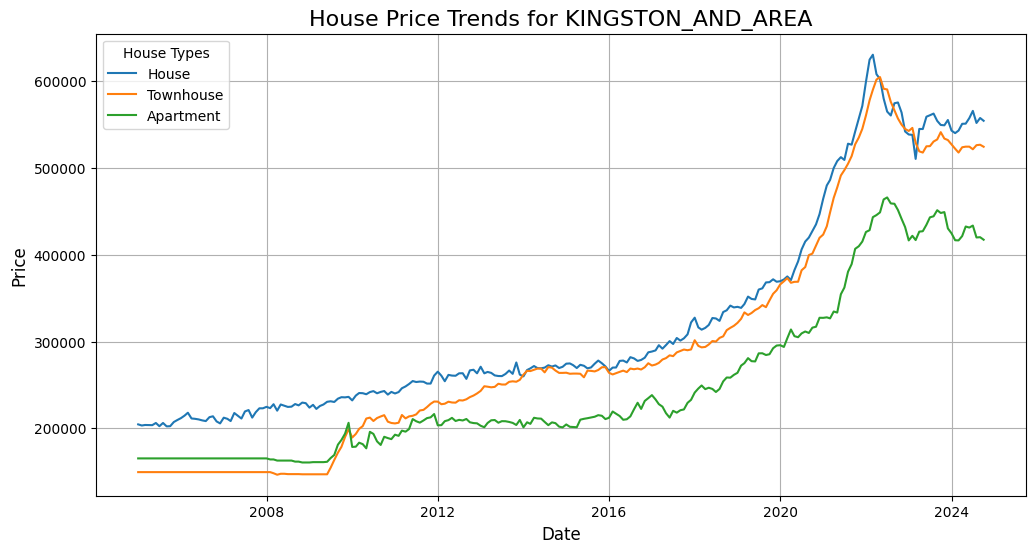

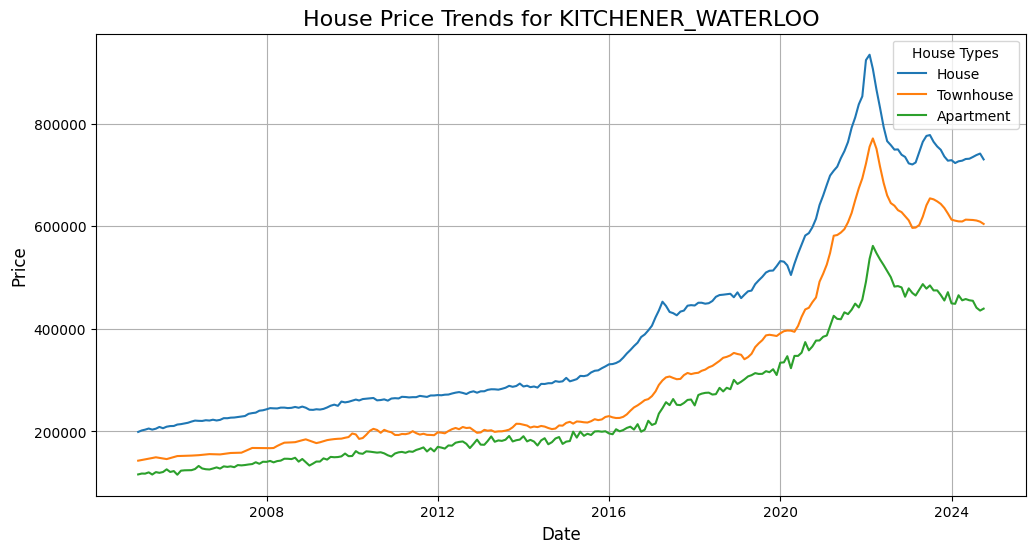

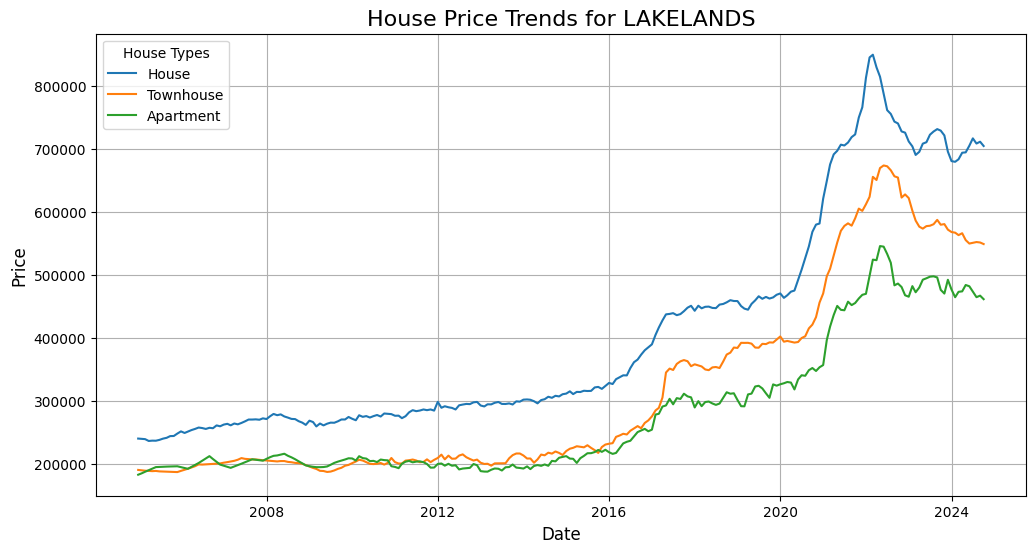

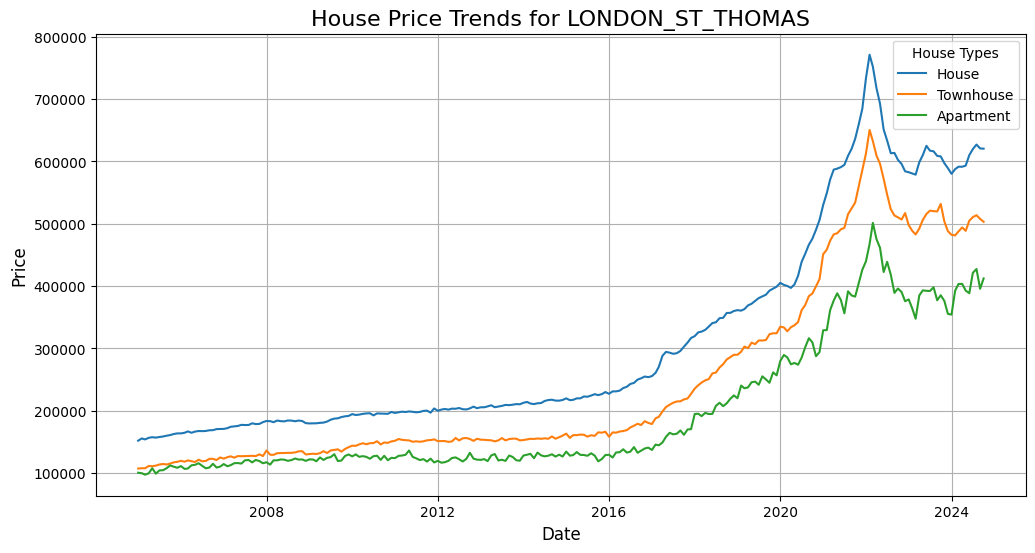

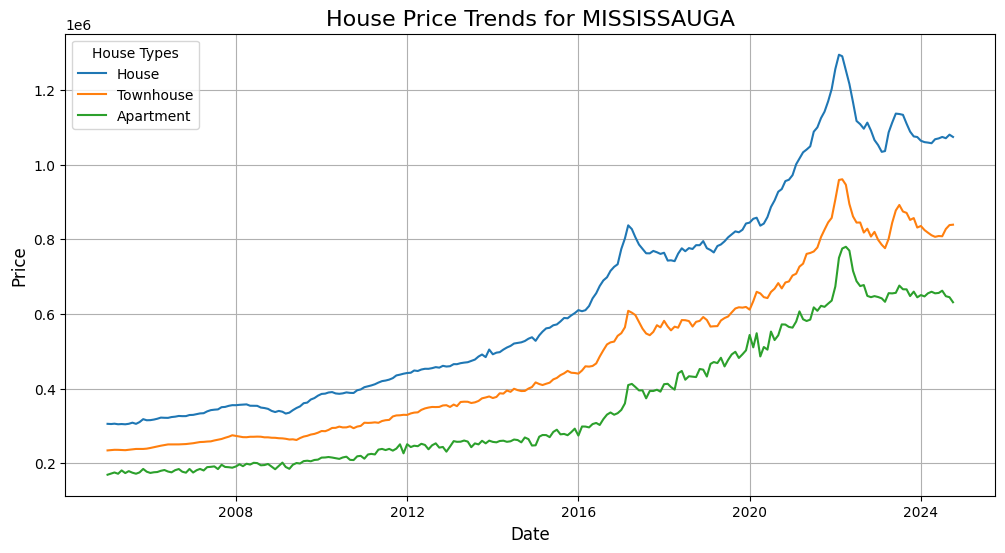

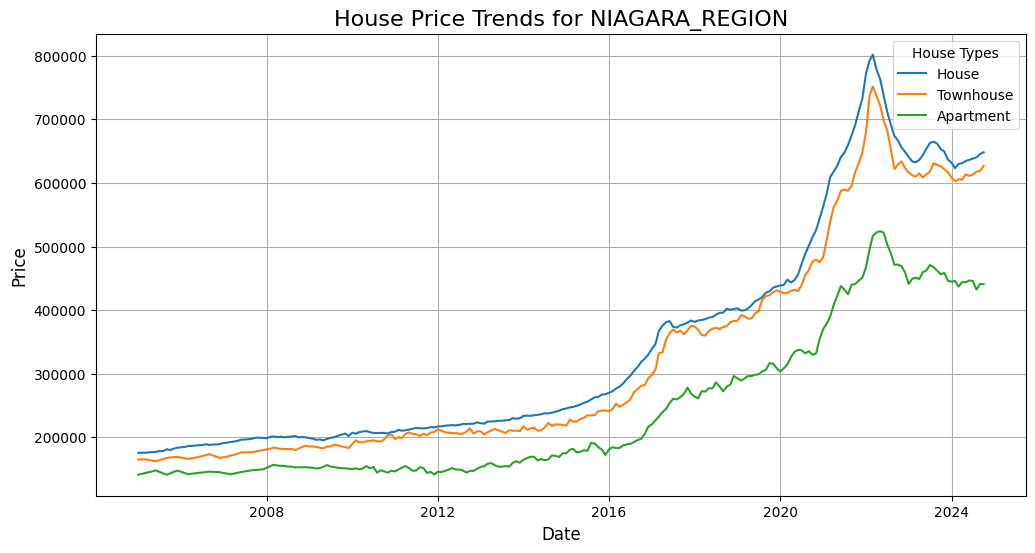

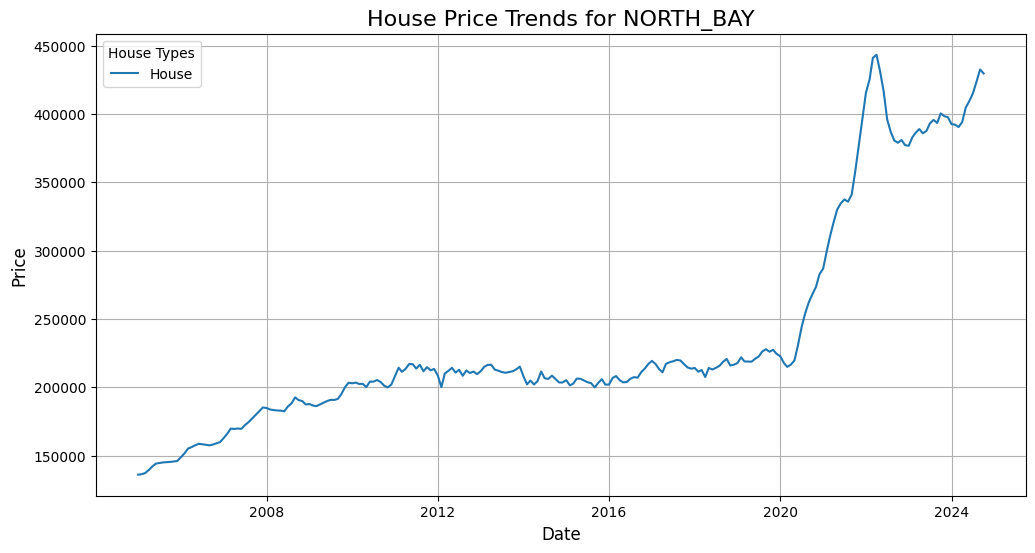

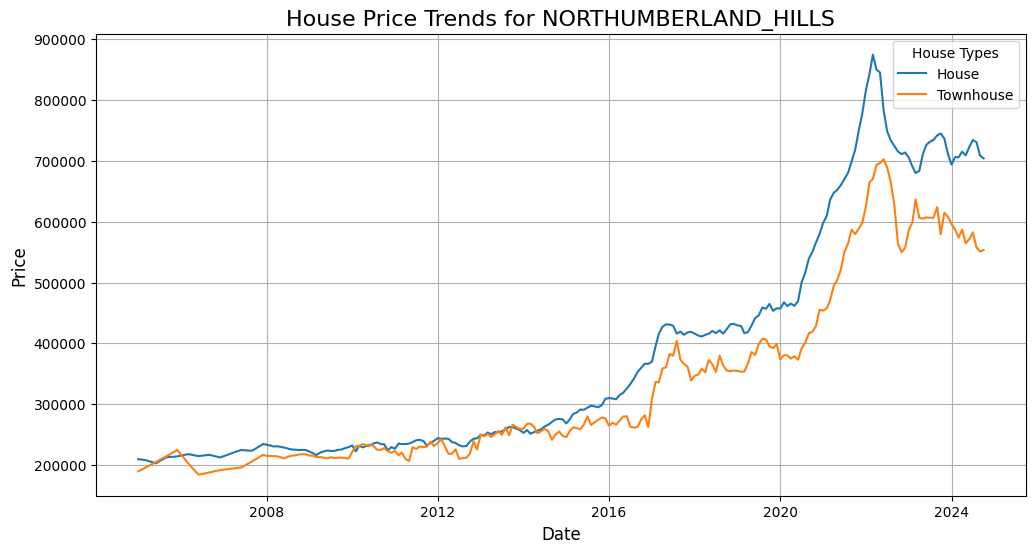

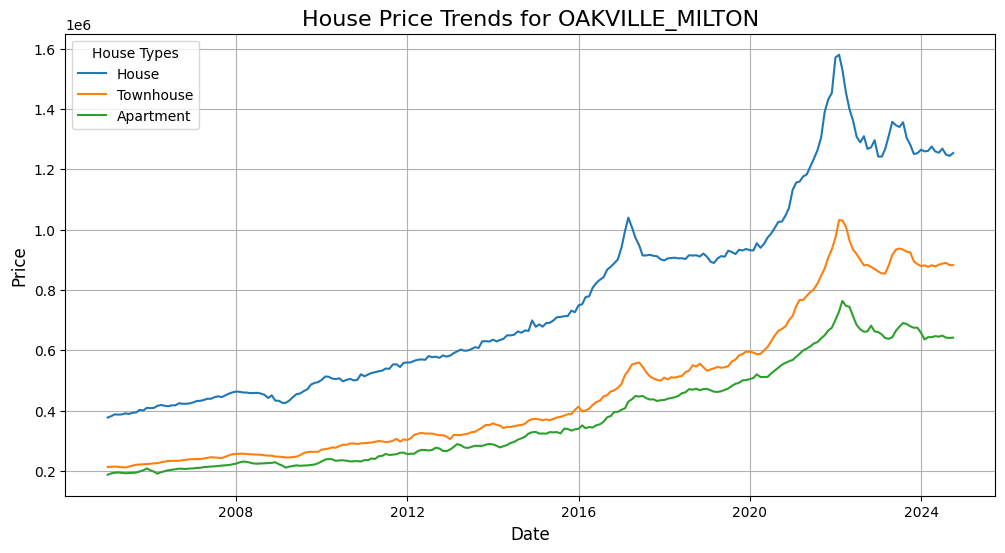

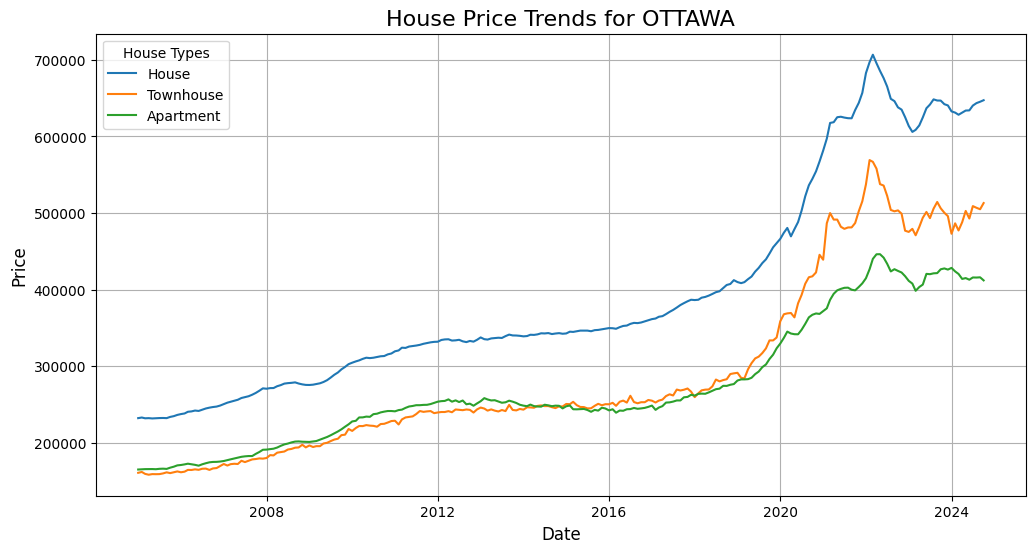

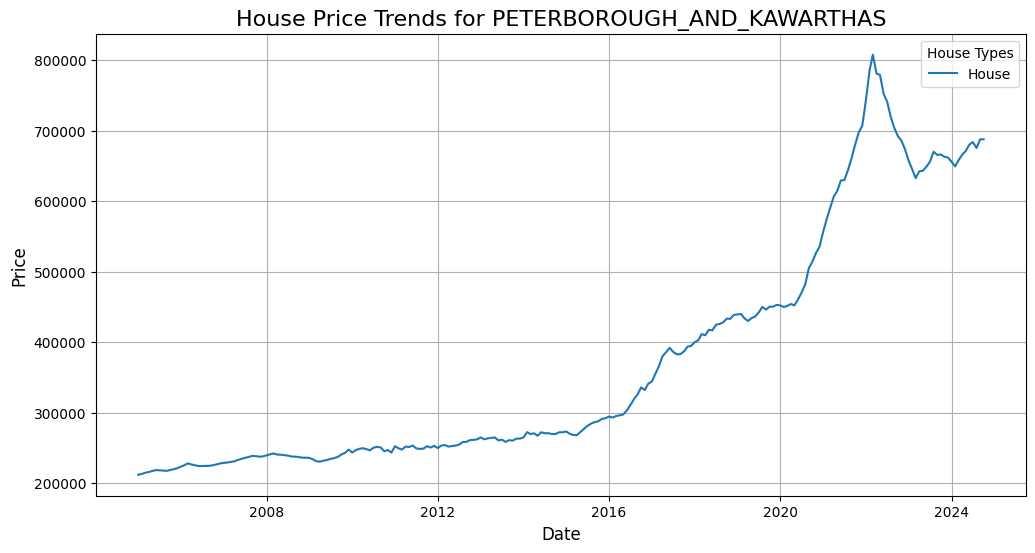

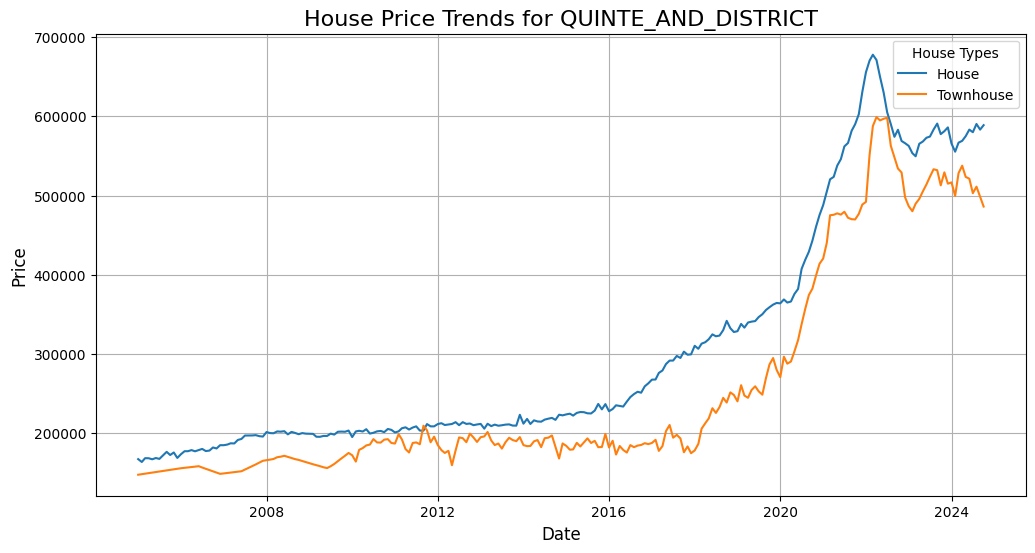

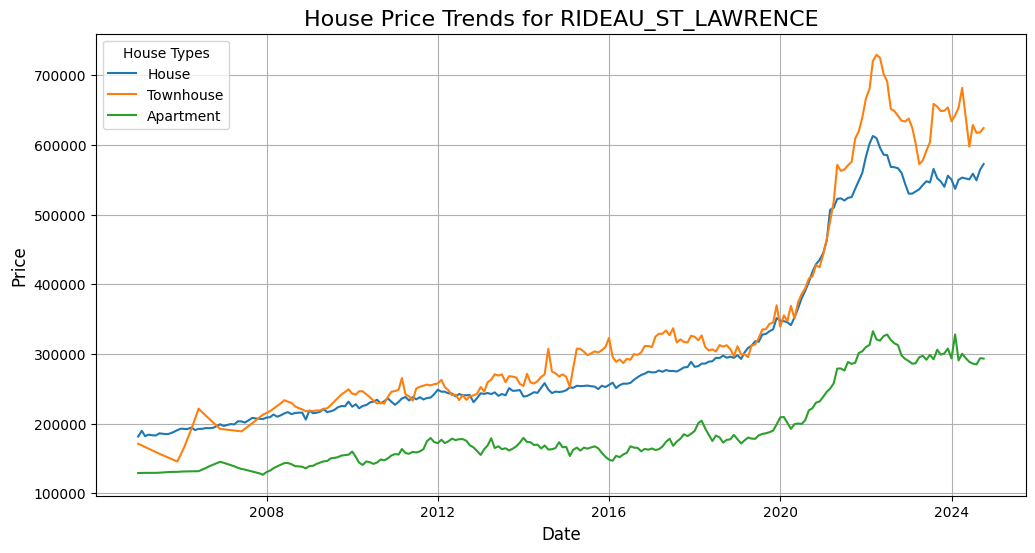

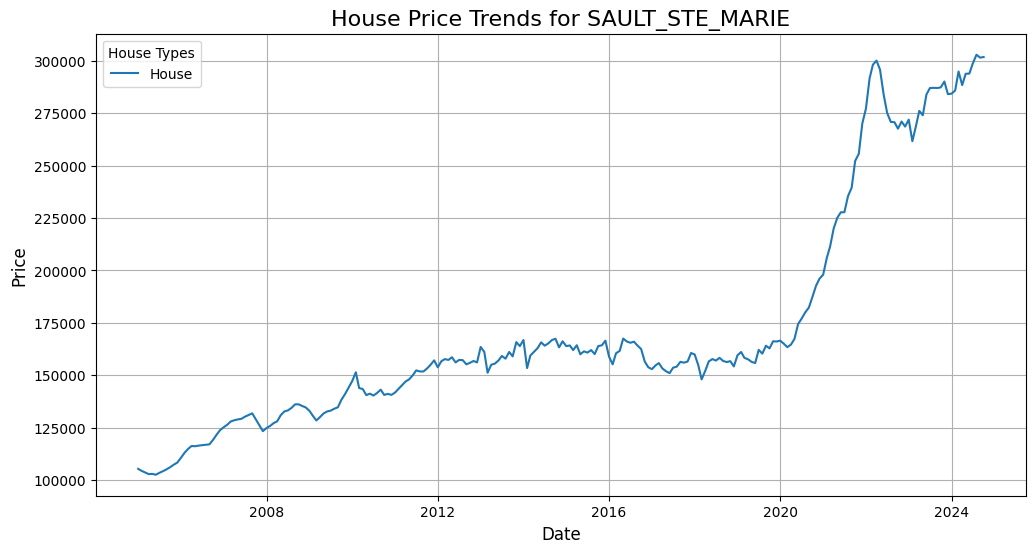

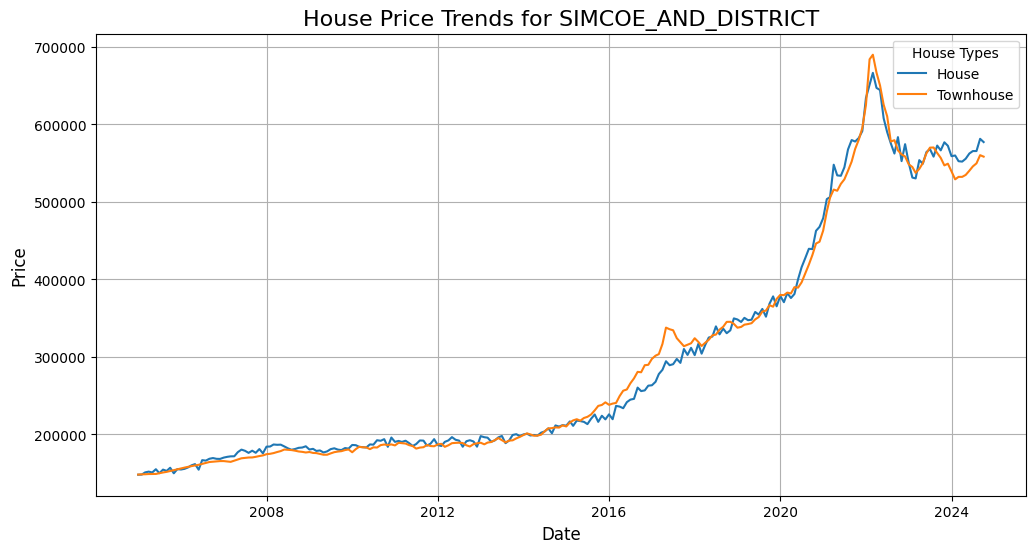

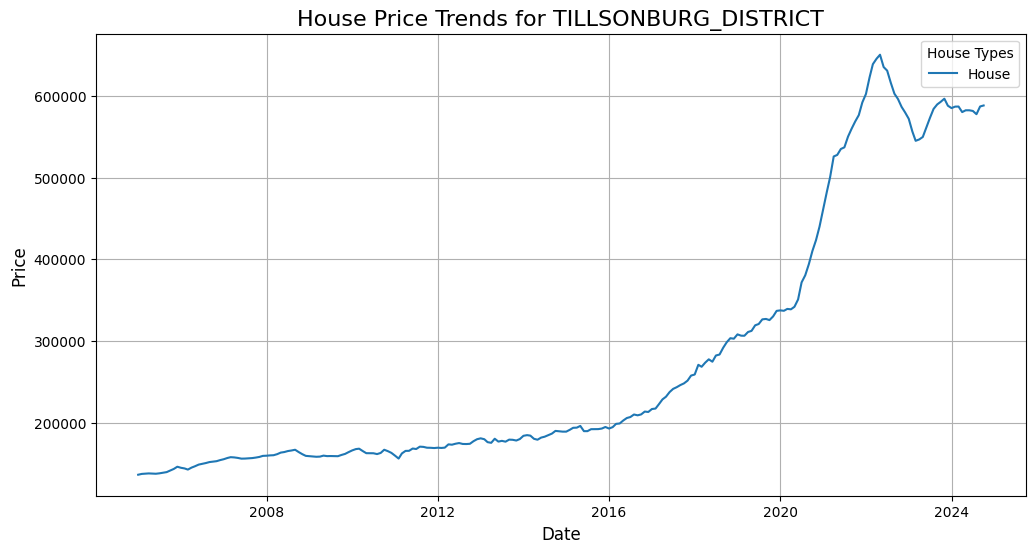

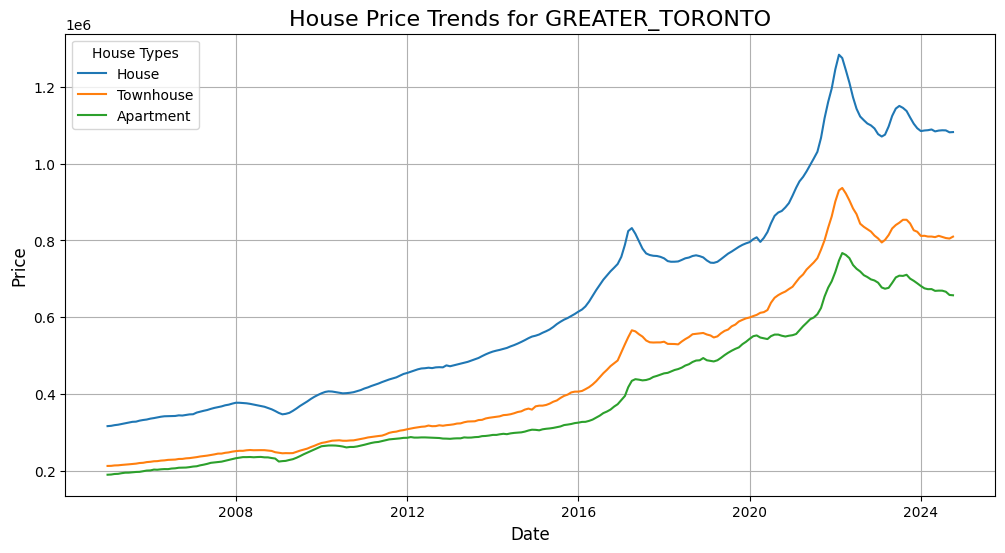

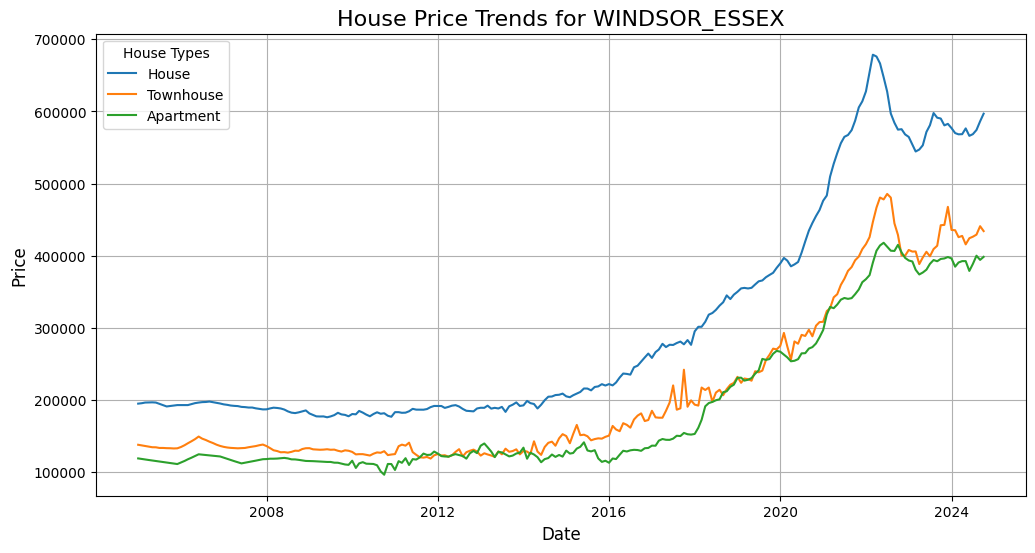

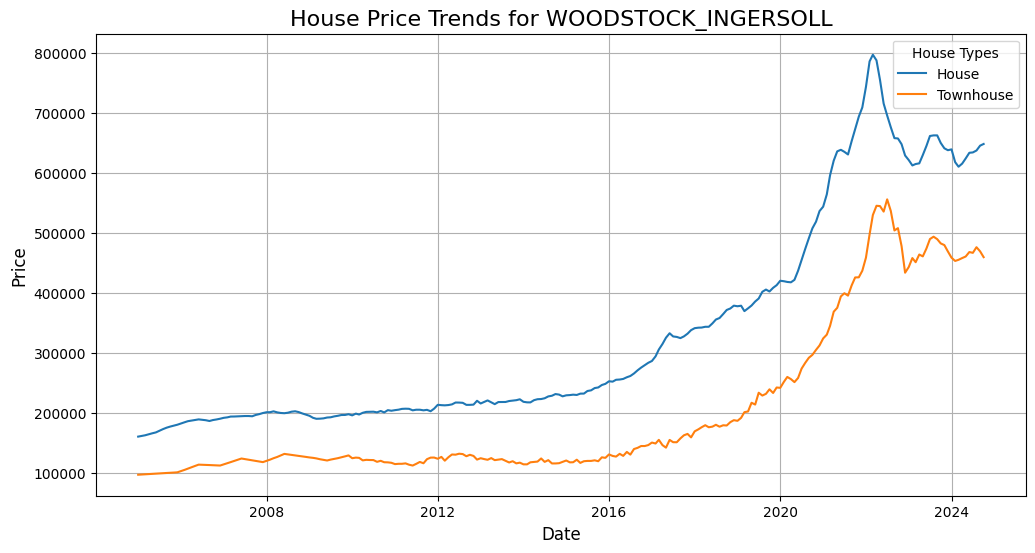

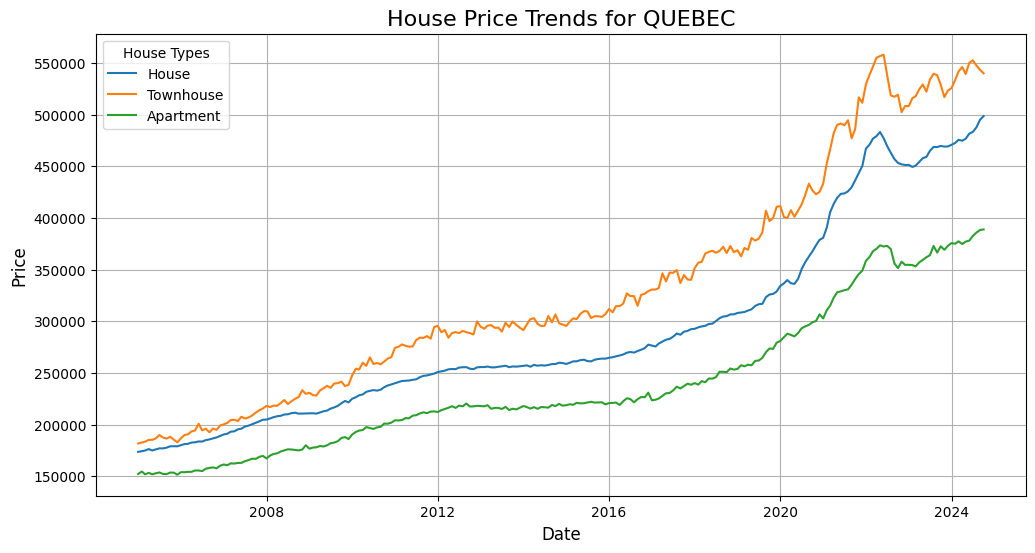

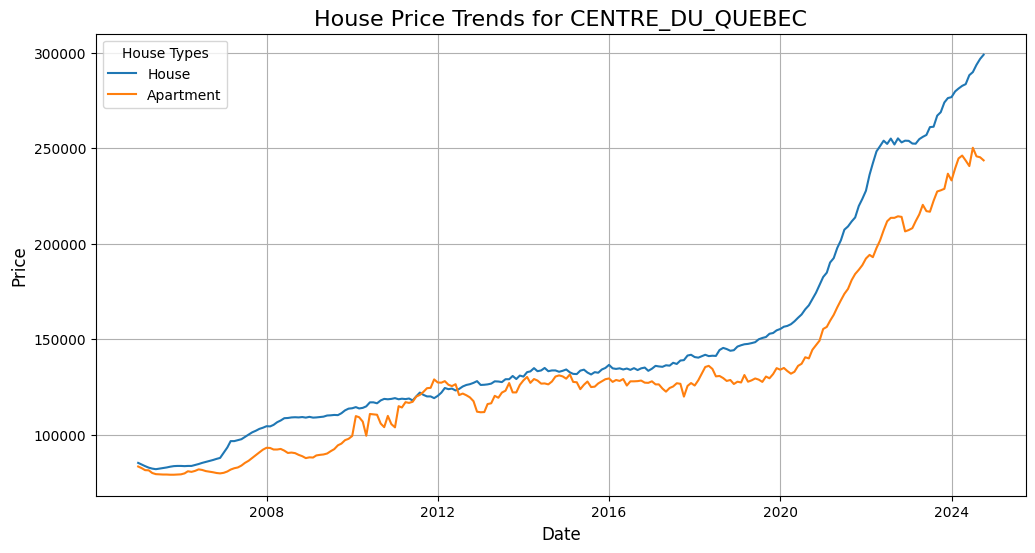

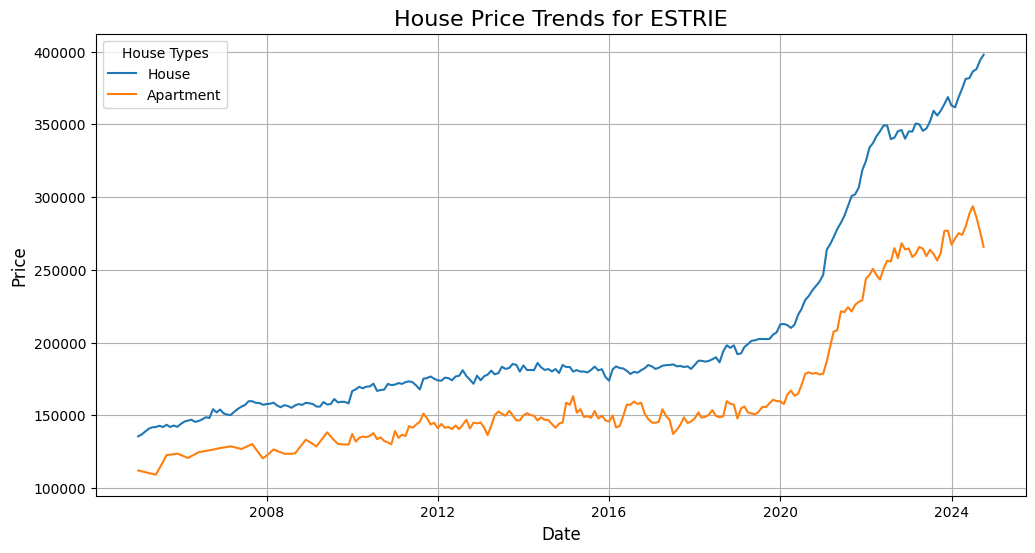

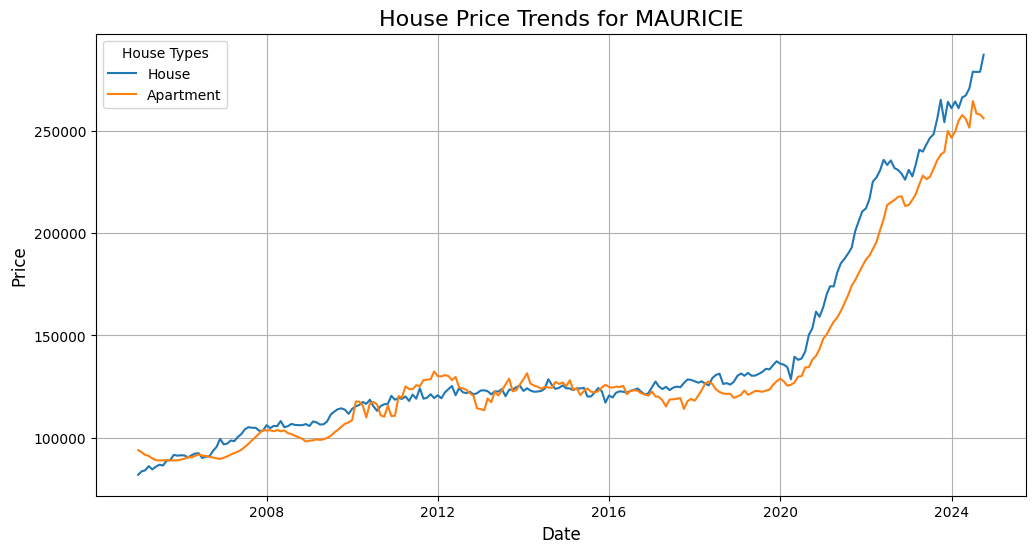

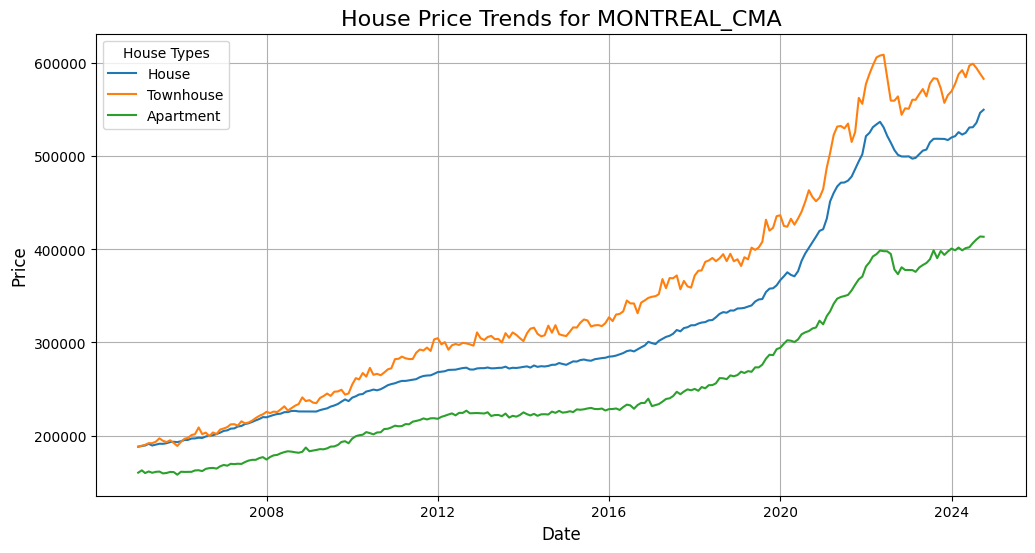

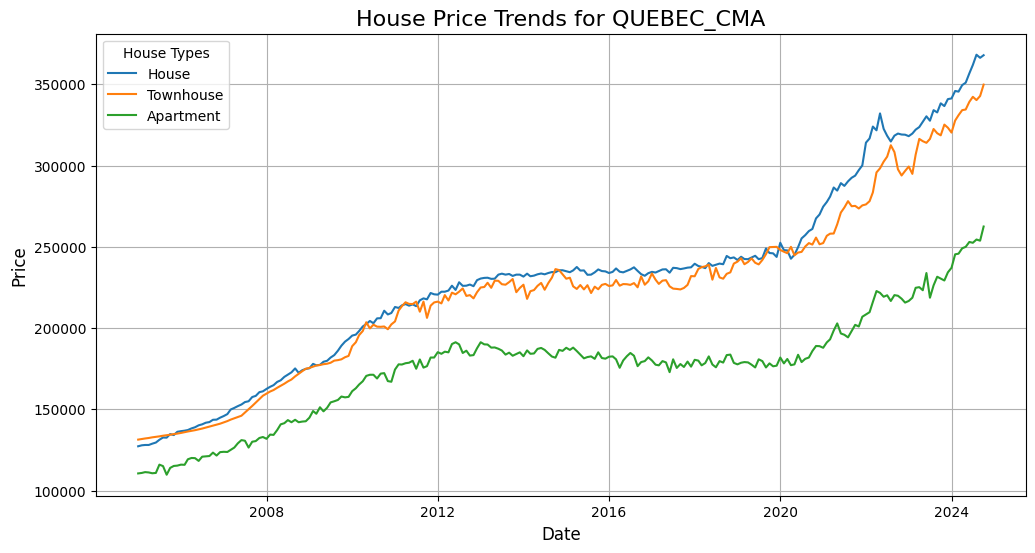

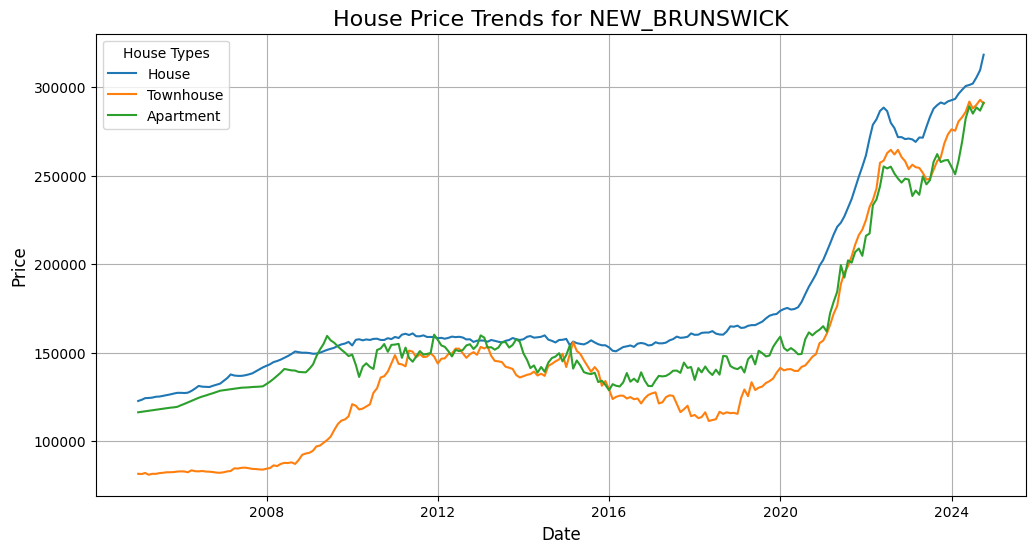

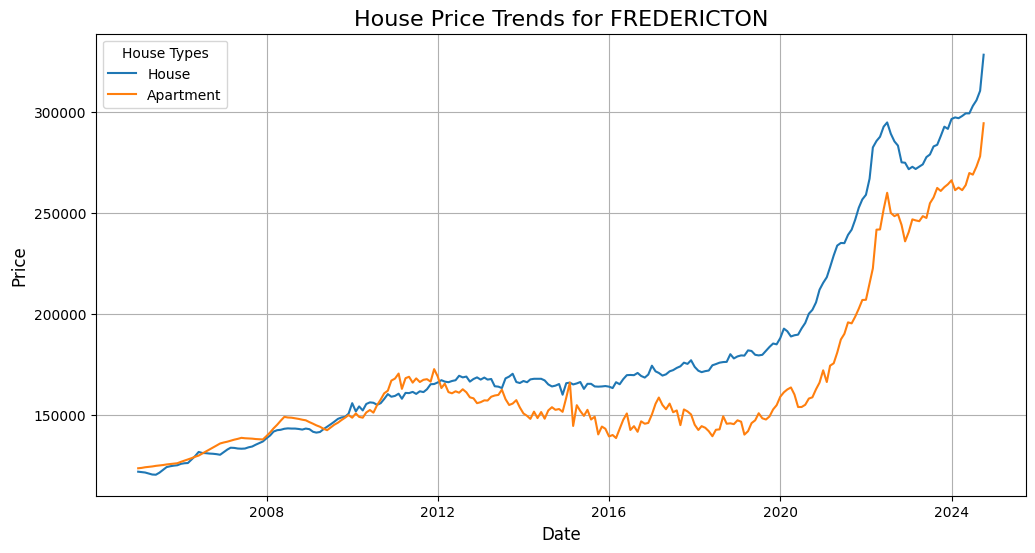

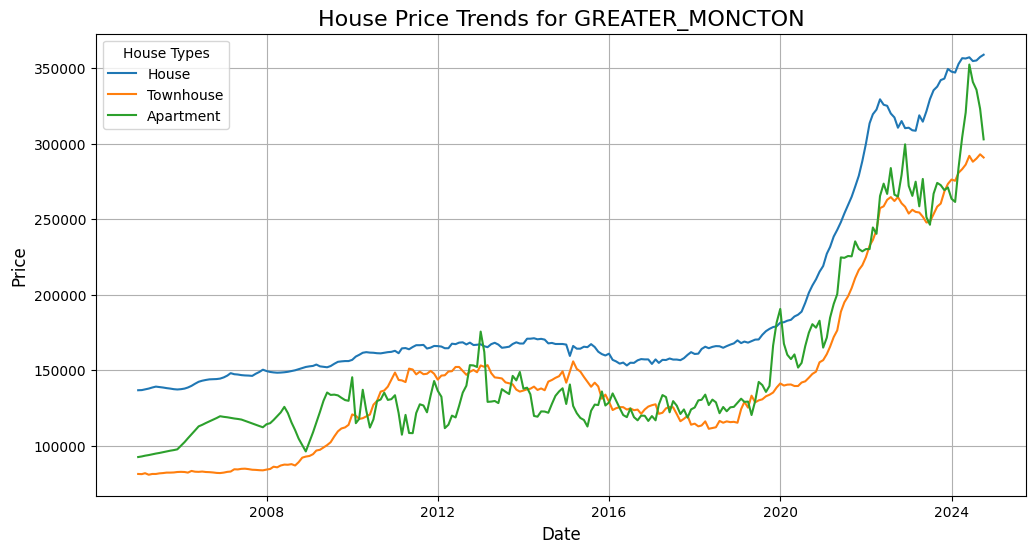

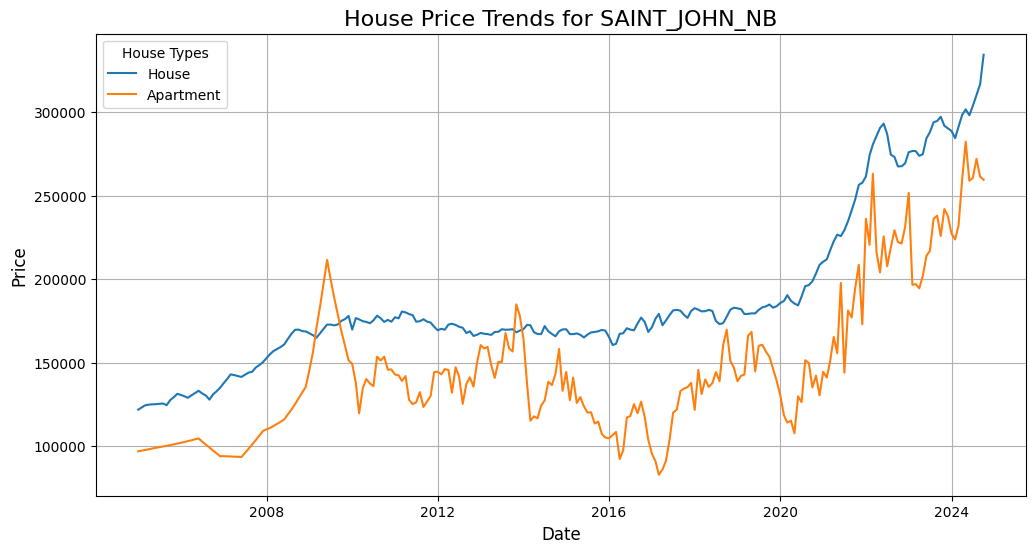

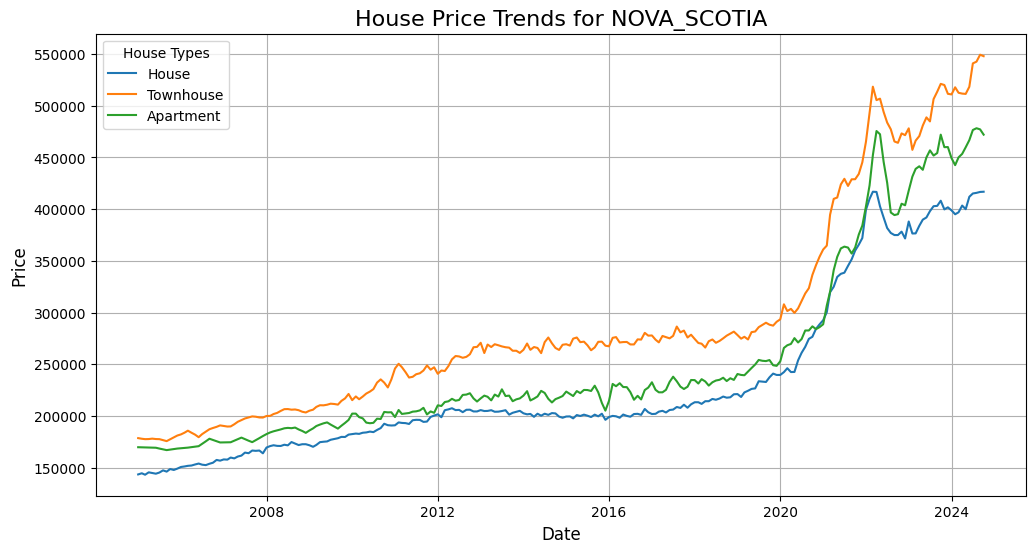

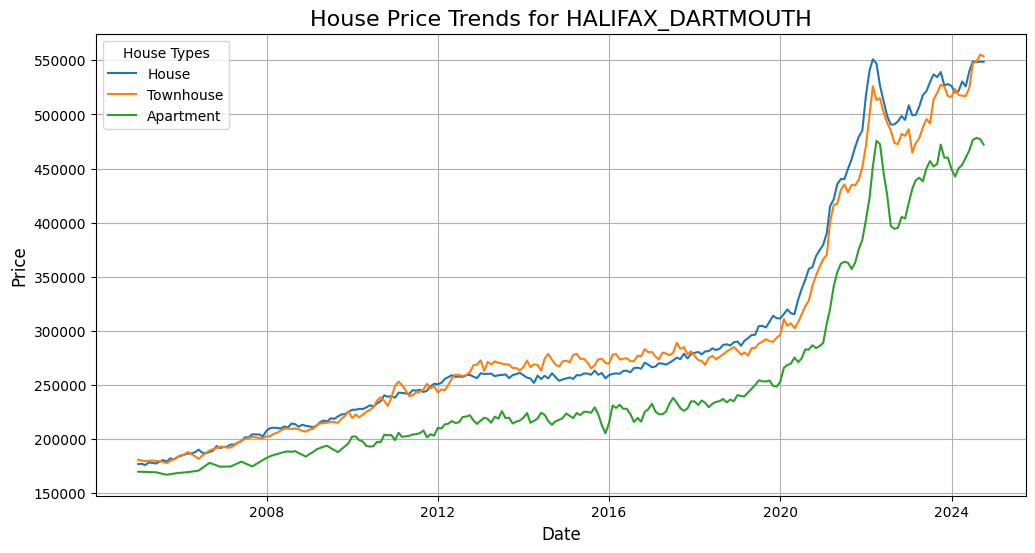

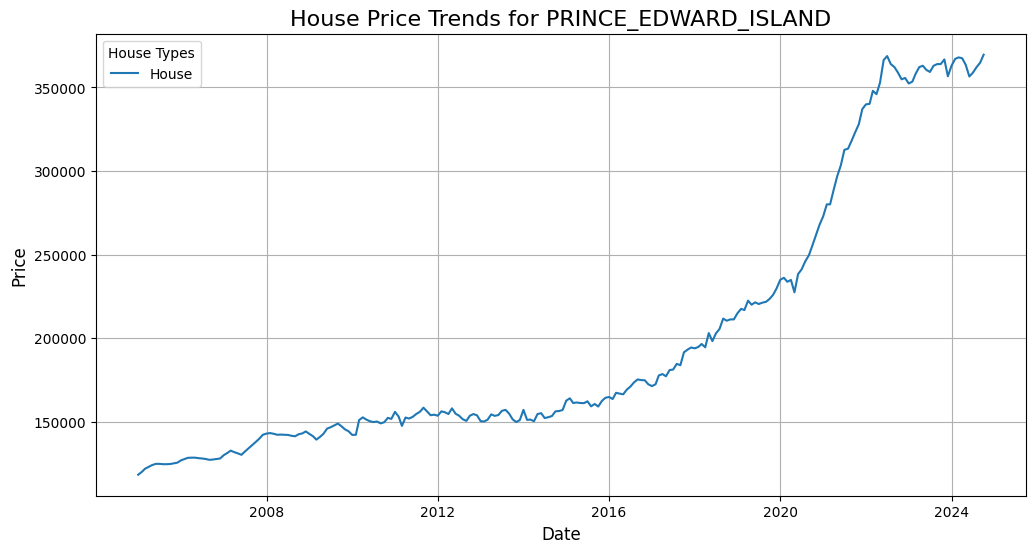

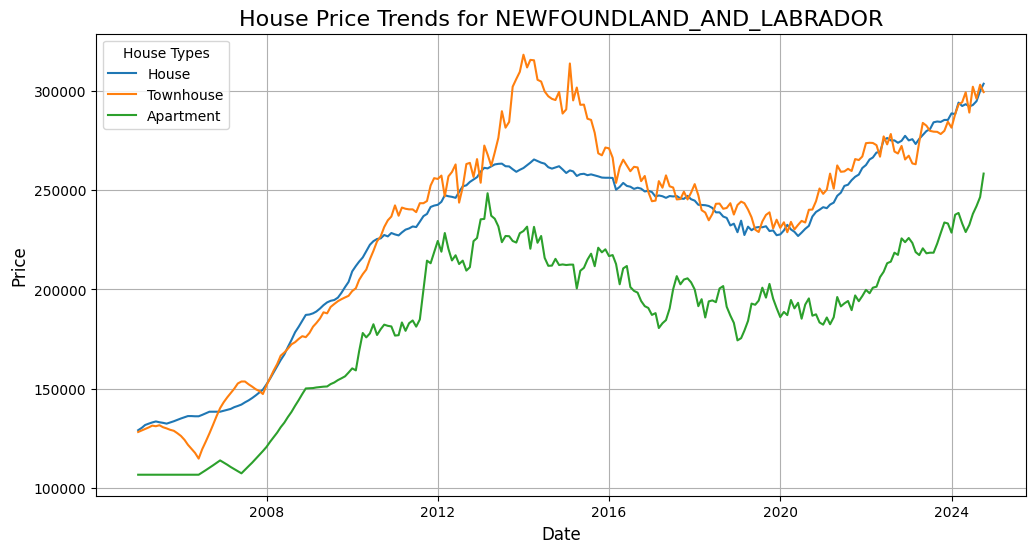

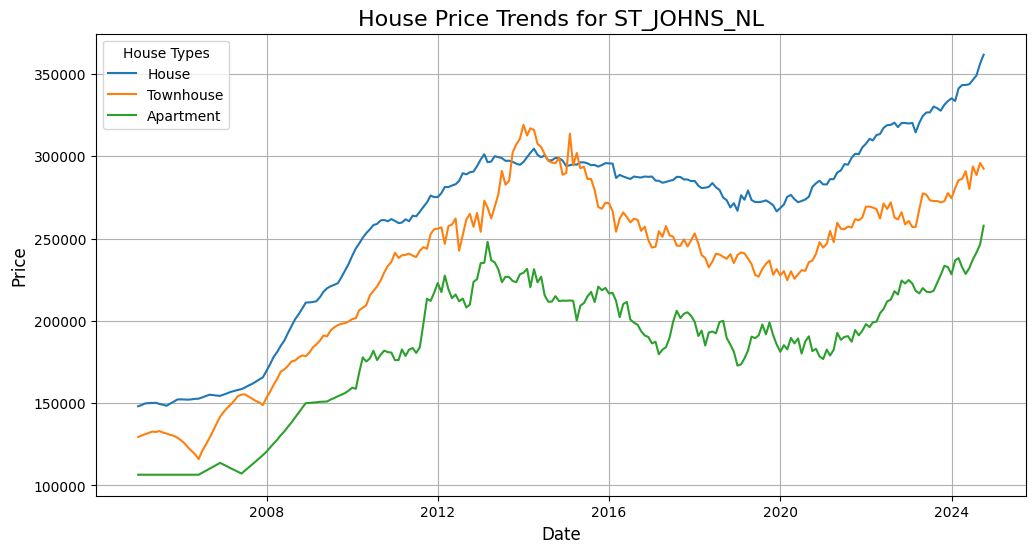

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt




for city_name, city_data in sheets_data.items():
    if 'Date' in city_data.columns:
        
        city_data['Date'] = pd.to_datetime(city_data['Date'])

        
        house_type_columns = [col for col in city_data.columns if col not in ['Date']]

        plt.figure(figsize=(12, 6))

        for house_type in house_type_columns:
            
            plt.plot(city_data['Date'], city_data[house_type], label=house_type)

        
        plt.title(f"House Price Trends for {city_name}", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Price", fontsize=12)
        plt.legend(title="House Types", fontsize=10)
        plt.grid(True)

        
        plt.show()
